# Concours
Lien vers le concours : https://www.kaggle.com/c/plant-pathology-2020-fgvc7

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import cv2
import tensorflow as ts

import warnings
warnings.filterwarnings("ignore")

In [4]:
LOCAL = True

if LOCAL is True:
    path_img = '/mnt/d/Google Drive/Compétition Plant Pathology/data/images/'
    path_train = '/mnt/d/Google Drive/Compétition Plant Pathology/data/train.csv'
    path_test = '/mnt/d/Google Drive/Compétition Plant Pathology/data/test.csv'
    path_submission = '/mnt/d/Google Drive/Compétition Plant Pathology/data/sample_submission.csv'
    path_img_processed = '/mnt/d/Google Drive/Compétition Plant Pathology/data/images_processed/'
else:
    path_img = '/content/drive/My Drive/Compétition Plan Pathology/data/images/'
    path_train = '/content/drive/My Drive/Compétition Plan Pathology/data/train.csv'
    path_test = '/content/drive/My Drive/Compétition Plan Pathology/data/test.csv'
    path_submission = '/content/drive/My Drive/Compétition Plan Pathology/data/sample_submission.csv'
    path_img_processed = '/content/drive/My Drive/Compétition Plan Pathology/data/images_processed/'

In [5]:
train = pd.read_csv(path_train)
test = pd.read_csv(path_test)
submission = pd.read_csv(path_submission)

sample_size = 50

In [6]:
train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [7]:
test.head()

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


In [8]:
def image_load(image_id):
  path = path_img + str(image_id) + '.jpg'
  #print(path)
  img = cv2.imread(path)
  del path
  return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [9]:
#loading images
train_img = train['image_id'][:sample_size].apply(image_load)

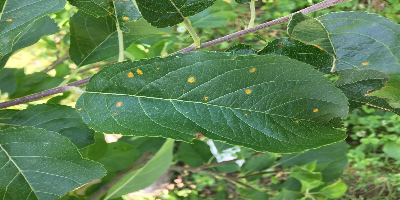

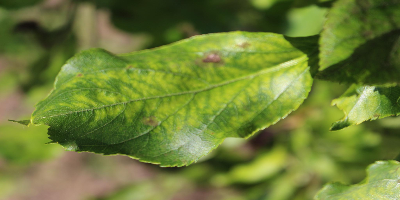

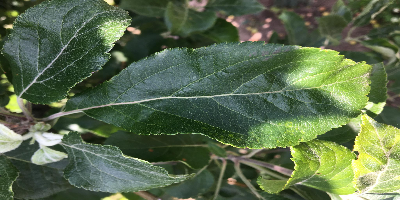

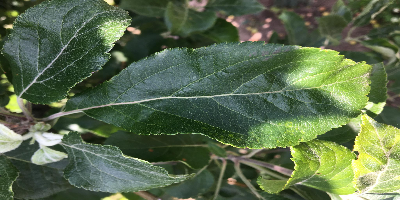

In [10]:
import PIL.Image
import IPython.display
def showarray(a):
    if LOCAL is True:
        import cv2
        from IPython.display import Image
        IPython.display.display(PIL.Image.fromarray(a))
    else:
        from google.colab.patches import cv2_imshow
        cv2_imshow(a)

#displaying 4 random images
showarray(cv2.resize(train_img[np.random.randint(0,sample_size)], (400,200)))
showarray(cv2.resize(train_img[np.random.randint(0,sample_size)], (400,200)))
showarray(cv2.resize(train_img[np.random.randint(0,sample_size)], (400,200)))
showarray(cv2.resize(train_img[np.random.randint(0,sample_size)], (400,200)))


# Edge Detection

raw image


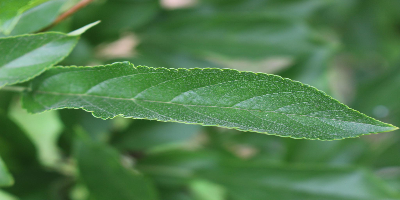


standard Canny


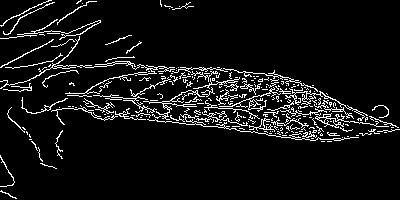


Canny with 5x5 gaussian convolution


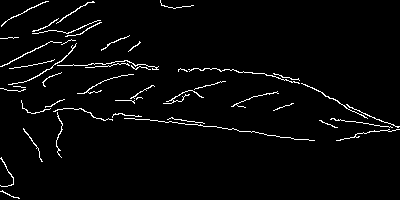


Canny with 7x7 gaussian convolution


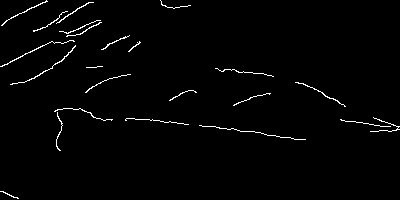

In [10]:
print('raw image')
showarray((cv2.resize(train_img[4], (400,200))))
print('\nstandard Canny')
showarray(cv2.Canny(cv2.resize(train_img[4], (400,200)), 100,200))
print('\nCanny with 5x5 gaussian convolution')
showarray(
    cv2.Canny(
        cv2.GaussianBlur(
            cv2.resize(train_img[4], (400,200)),
            (5,5),0),
        100,200)
    )
print('\nCanny with 7x7 gaussian convolution')
showarray(
    cv2.Canny(
        cv2.GaussianBlur(
            cv2.resize(train_img[4], (400,200)),
            (7,7),0),
        100,200)
    )

In [11]:
def resize(img, width, height):
  return cv2.resize(img, (width, height))

def edge_and_cut(img):
    ''''''
    edges = cv2.Canny(gaussianblur(img,7), 100, 200)
    edge_coors = []
    for i in range(edges.shape[0]):
        for j in range(edges.shape[1]):
            if edges[i][j] != 0:
                edge_coors.append((i, j))
    try:
        row_min = edge_coors[np.argsort([coor[0] for coor in edge_coors])[0]][0]
        row_max = edge_coors[np.argsort([coor[0] for coor in edge_coors])[-1]][0]
        col_min = edge_coors[np.argsort([coor[1] for coor in edge_coors])[0]][1]
        col_max = edge_coors[np.argsort([coor[1] for coor in edge_coors])[-1]][1]

        return cv2.resize(img[row_min:row_max, col_min:col_max], (400,200))
    except:
        return cv2.resize(img, (400,200))

def gaussianblur(img,size):
    return cv2.GaussianBlur(img, (size,size),0)

    

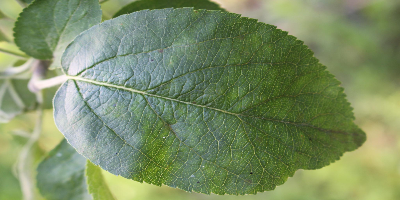

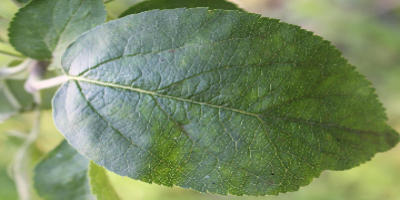

In [12]:
showarray(resize(train_img[5], 400,200))
showarray(edge_and_cut(resize(train_img[5], 400, 200)))

# Augmentation

- Voir notebook https://nbviewer.jupyter.org/github/aleju/imgaug-doc/blob/master/notebooks/A01%20-%20Load%20and%20Augment%20an%20Image.ipynb

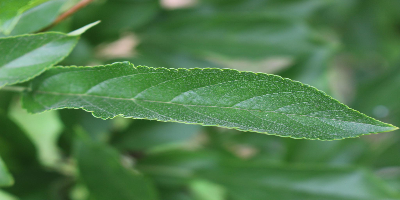

Augmented:


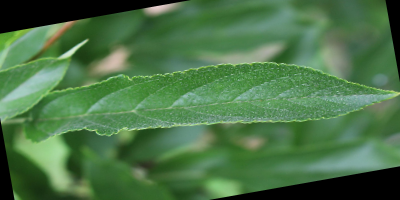

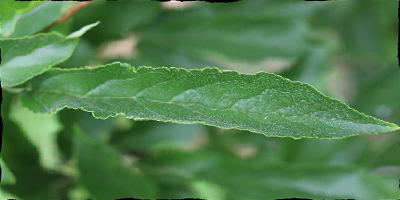

In [13]:
import imgaug as ia
from imgaug import augmenters as iaa

img_aug = resize(train_img[4], 400,200)
showarray(img_aug)
rotate = iaa.Affine(rotate=(-25, 25))
image_aug1 = rotate(image=img_aug)
elastic = iaa.ElasticTransformation(alpha=50, sigma=9)
image_aug2 = elastic(image=img_aug)

print("Augmented:")
showarray(image_aug1)
showarray(image_aug2)


In [14]:
import numpy as np
def random_brightness(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(img)
    scale = np.random.uniform(.8, 1.25)
    v = np.clip(v * scale, 0, 255, out=v)
    img = cv2.merge((h, s, v))
    img = cv2.cvtColor(img, cv2.COLOR_HSV2BGR)
    return img

def symetry(img):
  sim_x = cv2.flip(img, 0)  
  sim_y = cv2.flip(img, 1)
  sim_x_y = cv2.flip(sim_x, 1)
  return [img, sim_x, sim_y, sim_x_y]

def elastic(img):
  elastic_func = iaa.ElasticTransformation(alpha=50, sigma=9)
  return elastic_func(image = img)

# Process and Save

In [16]:
if LOCAL is False:
    from google.colab import drive
    drive.mount('/content/drive')

In [48]:
def process_and_save(img, image_id, treatment = 1):
    '''apply one of below treatments on one piture and saves obtained picture(s)
    #1 edge and cut
    #2 brightness / contrast
    #3 gaussian blur
    #4 data augmentation x4 : horizontal / vertical symetry
    #5 elastic'''

    img_list = []
    if treatment == 1:
        #1 edge and cut
        img_list.append(edge_and_cut(img))
        treatment_name = '1_edge_and_cut'
    elif treatment ==2:
        #2 brightness
        img_list.append(random_brightness(img))
        treatment_name = '2_brightness'
    elif treatment ==3:
        #3 gaussian blur
        img_list.append(gaussianblur(img, 7))
        treatment_name = '3_gaussian_blur'
    elif treatment ==4:
        #4 data augmentation horizontal/vertical symetry
        img_list = symetry(img)
        treatment_name = '4_symetry'
    elif treatment ==5:
        #elastic deformation
        img_list.append(elastic(img))
        treatment_name = '5_elastic'
    elif treatment ==6:
        #cumul
        img_list = symetry(gaussianblur(random_brightness(img),7))
        img_list = list([elastic(i) for i in img_list])
        treatment_name = '6_cumul_elastic'
    elif treatment ==7:
        #cumul sans elastic
        img_list = symetry(gaussianblur(random_brightness(img),7))
        treatment_name = '7_cumul_non_elastic'
        
    else:
        print('Unrecocignized treatment')
        return False

    for index, image in enumerate(img_list):
        if len(img_list) > 1:
            suffix = '__' + str(index)
        else:
            suffix = ''
        filename = str(image_id) + suffix + '.jpg'
        path = path_img_processed + treatment_name + '/' + filename
        try:
            PIL.Image.fromarray(image).save(path)
        except:
            print('/!\ Erreur d\'enregistrement : \n   * filename: {}\n   * path: {} /!\ \n'.format(filename,path))
    return True

In [19]:
#process_and_save(train_img[4], 'muche',4)

In [38]:
import glob

def load_process_save_dataset(path_orig, treatment_number = 1):
    if path_orig[-1] == '/':
        path_list = glob.glob(path_orig + '*')
    else:
        path_list = glob.glob(path_orig + '/*')
    path_list = [x.replace('\\', '/') for x in path_list]
    for i, path in enumerate(path_list):
        #loading images
        filename = path.split('/')[-1].split('.jpg')[-2]
        print('Traitement {}/{}: {}'.format(i+1, len(path_list), filename))
        img = cv2.imread(path)
        img =  cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #apply treatment
        process_and_save(img, filename, treatment = treatment_number)


In [39]:
path_img_processed_1 = 'data/images_processed/1_edge_and_cut'
load_process_save_dataset(path_img_processed_1, treatment_number = 2)

Traitement 1/3642: Test_0
Traitement 2/3642: Test_1
Traitement 3/3642: Test_10
Traitement 4/3642: Test_100
Traitement 5/3642: Test_1000
Traitement 6/3642: Test_1001
Traitement 7/3642: Test_1002
Traitement 8/3642: Test_1003
Traitement 9/3642: Test_1004
Traitement 10/3642: Test_1005
Traitement 11/3642: Test_1006
Traitement 12/3642: Test_1007
Traitement 13/3642: Test_1008
Traitement 14/3642: Test_1009
Traitement 15/3642: Test_101
Traitement 16/3642: Test_1010
Traitement 17/3642: Test_1011
Traitement 18/3642: Test_1012
Traitement 19/3642: Test_1013
Traitement 20/3642: Test_1014
Traitement 21/3642: Test_1015
Traitement 22/3642: Test_1016
Traitement 23/3642: Test_1017
Traitement 24/3642: Test_1018
Traitement 25/3642: Test_1019
Traitement 26/3642: Test_102
Traitement 27/3642: Test_1020
Traitement 28/3642: Test_1021
Traitement 29/3642: Test_1022
Traitement 30/3642: Test_1023
Traitement 31/3642: Test_1024
Traitement 32/3642: Test_1025
Traitement 33/3642: Test_1026
Traitement 34/3642: Test_1027


Traitement 274/3642: Test_1243
Traitement 275/3642: Test_1244
Traitement 276/3642: Test_1245
Traitement 277/3642: Test_1246
Traitement 278/3642: Test_1247
Traitement 279/3642: Test_1248
Traitement 280/3642: Test_1249
Traitement 281/3642: Test_125
Traitement 282/3642: Test_1250
Traitement 283/3642: Test_1251
Traitement 284/3642: Test_1252
Traitement 285/3642: Test_1253
Traitement 286/3642: Test_1254
Traitement 287/3642: Test_1255
Traitement 288/3642: Test_1256
Traitement 289/3642: Test_1257
Traitement 290/3642: Test_1258
Traitement 291/3642: Test_1259
Traitement 292/3642: Test_126
Traitement 293/3642: Test_1260
Traitement 294/3642: Test_1261
Traitement 295/3642: Test_1262
Traitement 296/3642: Test_1263
Traitement 297/3642: Test_1264
Traitement 298/3642: Test_1265
Traitement 299/3642: Test_1266
Traitement 300/3642: Test_1267
Traitement 301/3642: Test_1268
Traitement 302/3642: Test_1269
Traitement 303/3642: Test_127
Traitement 304/3642: Test_1270
Traitement 305/3642: Test_1271
Traitement 

Traitement 543/3642: Test_1486
Traitement 544/3642: Test_1487
Traitement 545/3642: Test_1488
Traitement 546/3642: Test_1489
Traitement 547/3642: Test_149
Traitement 548/3642: Test_1490
Traitement 549/3642: Test_1491
Traitement 550/3642: Test_1492
Traitement 551/3642: Test_1493
Traitement 552/3642: Test_1494
Traitement 553/3642: Test_1495
Traitement 554/3642: Test_1496
Traitement 555/3642: Test_1497
Traitement 556/3642: Test_1498
Traitement 557/3642: Test_1499
Traitement 558/3642: Test_15
Traitement 559/3642: Test_150
Traitement 560/3642: Test_1500
Traitement 561/3642: Test_1501
Traitement 562/3642: Test_1502
Traitement 563/3642: Test_1503
Traitement 564/3642: Test_1504
Traitement 565/3642: Test_1505
Traitement 566/3642: Test_1506
Traitement 567/3642: Test_1507
Traitement 568/3642: Test_1508
Traitement 569/3642: Test_1509
Traitement 570/3642: Test_151
Traitement 571/3642: Test_1510
Traitement 572/3642: Test_1511
Traitement 573/3642: Test_1512
Traitement 574/3642: Test_1513
Traitement 57

Traitement 811/3642: Test_1727
Traitement 812/3642: Test_1728
Traitement 813/3642: Test_1729
Traitement 814/3642: Test_173
Traitement 815/3642: Test_1730
Traitement 816/3642: Test_1731
Traitement 817/3642: Test_1732
Traitement 818/3642: Test_1733
Traitement 819/3642: Test_1734
Traitement 820/3642: Test_1735
Traitement 821/3642: Test_1736
Traitement 822/3642: Test_1737
Traitement 823/3642: Test_1738
Traitement 824/3642: Test_1739
Traitement 825/3642: Test_174
Traitement 826/3642: Test_1740
Traitement 827/3642: Test_1741
Traitement 828/3642: Test_1742
Traitement 829/3642: Test_1743
Traitement 830/3642: Test_1744
Traitement 831/3642: Test_1745
Traitement 832/3642: Test_1746
Traitement 833/3642: Test_1747
Traitement 834/3642: Test_1748
Traitement 835/3642: Test_1749
Traitement 836/3642: Test_175
Traitement 837/3642: Test_1750
Traitement 838/3642: Test_1751
Traitement 839/3642: Test_1752
Traitement 840/3642: Test_1753
Traitement 841/3642: Test_1754
Traitement 842/3642: Test_1755
Traitement 

Traitement 1085/3642: Test_335
Traitement 1086/3642: Test_336
Traitement 1087/3642: Test_337
Traitement 1088/3642: Test_338
Traitement 1089/3642: Test_339
Traitement 1090/3642: Test_34
Traitement 1091/3642: Test_340
Traitement 1092/3642: Test_341
Traitement 1093/3642: Test_342
Traitement 1094/3642: Test_343
Traitement 1095/3642: Test_344
Traitement 1096/3642: Test_345
Traitement 1097/3642: Test_346
Traitement 1098/3642: Test_347
Traitement 1099/3642: Test_348
Traitement 1100/3642: Test_349
Traitement 1101/3642: Test_35
Traitement 1102/3642: Test_350
Traitement 1103/3642: Test_351
Traitement 1104/3642: Test_352
Traitement 1105/3642: Test_353
Traitement 1106/3642: Test_354
Traitement 1107/3642: Test_355
Traitement 1108/3642: Test_356
Traitement 1109/3642: Test_357
Traitement 1110/3642: Test_358
Traitement 1111/3642: Test_359
Traitement 1112/3642: Test_36
Traitement 1113/3642: Test_360
Traitement 1114/3642: Test_361
Traitement 1115/3642: Test_362
Traitement 1116/3642: Test_363
Traitement 

Traitement 1355/3642: Test_579
Traitement 1356/3642: Test_58
Traitement 1357/3642: Test_580
Traitement 1358/3642: Test_581
Traitement 1359/3642: Test_582
Traitement 1360/3642: Test_583
Traitement 1361/3642: Test_584
Traitement 1362/3642: Test_585
Traitement 1363/3642: Test_586
Traitement 1364/3642: Test_587
Traitement 1365/3642: Test_588
Traitement 1366/3642: Test_589
Traitement 1367/3642: Test_59
Traitement 1368/3642: Test_590
Traitement 1369/3642: Test_591
Traitement 1370/3642: Test_592
Traitement 1371/3642: Test_593
Traitement 1372/3642: Test_594
Traitement 1373/3642: Test_595
Traitement 1374/3642: Test_596
Traitement 1375/3642: Test_597
Traitement 1376/3642: Test_598
Traitement 1377/3642: Test_599
Traitement 1378/3642: Test_6
Traitement 1379/3642: Test_60
Traitement 1380/3642: Test_600
Traitement 1381/3642: Test_601
Traitement 1382/3642: Test_602
Traitement 1383/3642: Test_603
Traitement 1384/3642: Test_604
Traitement 1385/3642: Test_605
Traitement 1386/3642: Test_606
Traitement 13

Traitement 1625/3642: Test_821
Traitement 1626/3642: Test_822
Traitement 1627/3642: Test_823
Traitement 1628/3642: Test_824
Traitement 1629/3642: Test_825
Traitement 1630/3642: Test_826
Traitement 1631/3642: Test_827
Traitement 1632/3642: Test_828
Traitement 1633/3642: Test_829
Traitement 1634/3642: Test_83
Traitement 1635/3642: Test_830
Traitement 1636/3642: Test_831
Traitement 1637/3642: Test_832
Traitement 1638/3642: Test_833
Traitement 1639/3642: Test_834
Traitement 1640/3642: Test_835
Traitement 1641/3642: Test_836
Traitement 1642/3642: Test_837
Traitement 1643/3642: Test_838
Traitement 1644/3642: Test_839
Traitement 1645/3642: Test_84
Traitement 1646/3642: Test_840
Traitement 1647/3642: Test_841
Traitement 1648/3642: Test_842
Traitement 1649/3642: Test_843
Traitement 1650/3642: Test_844
Traitement 1651/3642: Test_845
Traitement 1652/3642: Test_846
Traitement 1653/3642: Test_847
Traitement 1654/3642: Test_848
Traitement 1655/3642: Test_849
Traitement 1656/3642: Test_85
Traitement 

Traitement 1894/3642: Train_1062
Traitement 1895/3642: Train_1063
Traitement 1896/3642: Train_1064
Traitement 1897/3642: Train_1065
Traitement 1898/3642: Train_1066
Traitement 1899/3642: Train_1067
Traitement 1900/3642: Train_1068
Traitement 1901/3642: Train_1069
Traitement 1902/3642: Train_107
Traitement 1903/3642: Train_1070
Traitement 1904/3642: Train_1071
Traitement 1905/3642: Train_1072
Traitement 1906/3642: Train_1073
Traitement 1907/3642: Train_1074
Traitement 1908/3642: Train_1075
Traitement 1909/3642: Train_1076
Traitement 1910/3642: Train_1077
Traitement 1911/3642: Train_1078
Traitement 1912/3642: Train_1079
Traitement 1913/3642: Train_108
Traitement 1914/3642: Train_1080
Traitement 1915/3642: Train_1081
Traitement 1916/3642: Train_1082
Traitement 1917/3642: Train_1083
Traitement 1918/3642: Train_1084
Traitement 1919/3642: Train_1085
Traitement 1920/3642: Train_1086
Traitement 1921/3642: Train_1087
Traitement 1922/3642: Train_1088
Traitement 1923/3642: Train_1089
Traitement 1

Traitement 2144/3642: Train_1288
Traitement 2145/3642: Train_1289
Traitement 2146/3642: Train_129
Traitement 2147/3642: Train_1290
Traitement 2148/3642: Train_1291
Traitement 2149/3642: Train_1292
Traitement 2150/3642: Train_1293
Traitement 2151/3642: Train_1294
Traitement 2152/3642: Train_1295
Traitement 2153/3642: Train_1296
Traitement 2154/3642: Train_1297
Traitement 2155/3642: Train_1298
Traitement 2156/3642: Train_1299
Traitement 2157/3642: Train_13
Traitement 2158/3642: Train_130
Traitement 2159/3642: Train_1300
Traitement 2160/3642: Train_1301
Traitement 2161/3642: Train_1302
Traitement 2162/3642: Train_1303
Traitement 2163/3642: Train_1304
Traitement 2164/3642: Train_1305
Traitement 2165/3642: Train_1306
Traitement 2166/3642: Train_1307
Traitement 2167/3642: Train_1308
Traitement 2168/3642: Train_1309
Traitement 2169/3642: Train_131
Traitement 2170/3642: Train_1310
Traitement 2171/3642: Train_1311
Traitement 2172/3642: Train_1312
Traitement 2173/3642: Train_1313
Traitement 2174

Traitement 2401/3642: Train_1519
Traitement 2402/3642: Train_152
Traitement 2403/3642: Train_1520
Traitement 2404/3642: Train_1521
Traitement 2405/3642: Train_1522
Traitement 2406/3642: Train_1523
Traitement 2407/3642: Train_1524
Traitement 2408/3642: Train_1525
Traitement 2409/3642: Train_1526
Traitement 2410/3642: Train_1527
Traitement 2411/3642: Train_1528
Traitement 2412/3642: Train_1529
Traitement 2413/3642: Train_153
Traitement 2414/3642: Train_1530
Traitement 2415/3642: Train_1531
Traitement 2416/3642: Train_1532
Traitement 2417/3642: Train_1533
Traitement 2418/3642: Train_1534
Traitement 2419/3642: Train_1535
Traitement 2420/3642: Train_1536
Traitement 2421/3642: Train_1537
Traitement 2422/3642: Train_1538
Traitement 2423/3642: Train_1539
Traitement 2424/3642: Train_154
Traitement 2425/3642: Train_1540
Traitement 2426/3642: Train_1541
Traitement 2427/3642: Train_1542
Traitement 2428/3642: Train_1543
Traitement 2429/3642: Train_1544
Traitement 2430/3642: Train_1545
Traitement 24

Traitement 2655/3642: Train_1748
Traitement 2656/3642: Train_1749
Traitement 2657/3642: Train_175
Traitement 2658/3642: Train_1750
Traitement 2659/3642: Train_1751
Traitement 2660/3642: Train_1752
Traitement 2661/3642: Train_1753
Traitement 2662/3642: Train_1754
Traitement 2663/3642: Train_1755
Traitement 2664/3642: Train_1756
Traitement 2665/3642: Train_1757
Traitement 2666/3642: Train_1758
Traitement 2667/3642: Train_1759
Traitement 2668/3642: Train_176
Traitement 2669/3642: Train_1760
Traitement 2670/3642: Train_1761
Traitement 2671/3642: Train_1762
Traitement 2672/3642: Train_1763
Traitement 2673/3642: Train_1764
Traitement 2674/3642: Train_1765
Traitement 2675/3642: Train_1766
Traitement 2676/3642: Train_1767
Traitement 2677/3642: Train_1768
Traitement 2678/3642: Train_1769
Traitement 2679/3642: Train_177
Traitement 2680/3642: Train_1770
Traitement 2681/3642: Train_1771
Traitement 2682/3642: Train_1772
Traitement 2683/3642: Train_1773
Traitement 2684/3642: Train_1774
Traitement 26

Traitement 2911/3642: Train_34
Traitement 2912/3642: Train_340
Traitement 2913/3642: Train_341
Traitement 2914/3642: Train_342
Traitement 2915/3642: Train_343
Traitement 2916/3642: Train_344
Traitement 2917/3642: Train_345
Traitement 2918/3642: Train_346
Traitement 2919/3642: Train_347
Traitement 2920/3642: Train_348
Traitement 2921/3642: Train_349
Traitement 2922/3642: Train_35
Traitement 2923/3642: Train_350
Traitement 2924/3642: Train_351
Traitement 2925/3642: Train_352
Traitement 2926/3642: Train_353
Traitement 2927/3642: Train_354
Traitement 2928/3642: Train_355
Traitement 2929/3642: Train_356
Traitement 2930/3642: Train_357
Traitement 2931/3642: Train_358
Traitement 2932/3642: Train_359
Traitement 2933/3642: Train_36
Traitement 2934/3642: Train_360
Traitement 2935/3642: Train_361
Traitement 2936/3642: Train_362
Traitement 2937/3642: Train_363
Traitement 2938/3642: Train_364
Traitement 2939/3642: Train_365
Traitement 2940/3642: Train_366
Traitement 2941/3642: Train_367
Traitement 

Traitement 3168/3642: Train_571
Traitement 3169/3642: Train_572
Traitement 3170/3642: Train_573
Traitement 3171/3642: Train_574
Traitement 3172/3642: Train_575
Traitement 3173/3642: Train_576
Traitement 3174/3642: Train_577
Traitement 3175/3642: Train_578
Traitement 3176/3642: Train_579
Traitement 3177/3642: Train_58
Traitement 3178/3642: Train_580
Traitement 3179/3642: Train_581
Traitement 3180/3642: Train_582
Traitement 3181/3642: Train_583
Traitement 3182/3642: Train_584
Traitement 3183/3642: Train_585
Traitement 3184/3642: Train_586
Traitement 3185/3642: Train_587
Traitement 3186/3642: Train_588
Traitement 3187/3642: Train_589
Traitement 3188/3642: Train_59
Traitement 3189/3642: Train_590
Traitement 3190/3642: Train_591
Traitement 3191/3642: Train_592
Traitement 3192/3642: Train_593
Traitement 3193/3642: Train_594
Traitement 3194/3642: Train_595
Traitement 3195/3642: Train_596
Traitement 3196/3642: Train_597
Traitement 3197/3642: Train_598
Traitement 3198/3642: Train_599
Traitement

Traitement 3427/3642: Train_804
Traitement 3428/3642: Train_805
Traitement 3429/3642: Train_806
Traitement 3430/3642: Train_807
Traitement 3431/3642: Train_808
Traitement 3432/3642: Train_809
Traitement 3433/3642: Train_81
Traitement 3434/3642: Train_810
Traitement 3435/3642: Train_811
Traitement 3436/3642: Train_812
Traitement 3437/3642: Train_813
Traitement 3438/3642: Train_814
Traitement 3439/3642: Train_815
Traitement 3440/3642: Train_816
Traitement 3441/3642: Train_817
Traitement 3442/3642: Train_818
Traitement 3443/3642: Train_819
Traitement 3444/3642: Train_82
Traitement 3445/3642: Train_820
Traitement 3446/3642: Train_821
Traitement 3447/3642: Train_822
Traitement 3448/3642: Train_823
Traitement 3449/3642: Train_824
Traitement 3450/3642: Train_825
Traitement 3451/3642: Train_826
Traitement 3452/3642: Train_827
Traitement 3453/3642: Train_828
Traitement 3454/3642: Train_829
Traitement 3455/3642: Train_83
Traitement 3456/3642: Train_830
Traitement 3457/3642: Train_831
Traitement 

In [44]:
path_img_processed_2 = 'data/images_processed/1_edge_and_cut'
load_process_save_dataset(path_img_processed_2, treatment_number = 3)

Traitement 1/3642: Test_0
Gaussian blur
Traitement 2/3642: Test_1
Gaussian blur
Traitement 3/3642: Test_10
Gaussian blur
Traitement 4/3642: Test_100
Gaussian blur
Traitement 5/3642: Test_1000
Gaussian blur
Traitement 6/3642: Test_1001
Gaussian blur
Traitement 7/3642: Test_1002
Gaussian blur
Traitement 8/3642: Test_1003
Gaussian blur
Traitement 9/3642: Test_1004
Gaussian blur
Traitement 10/3642: Test_1005
Gaussian blur
Traitement 11/3642: Test_1006
Gaussian blur
Traitement 12/3642: Test_1007
Gaussian blur
Traitement 13/3642: Test_1008
Gaussian blur
Traitement 14/3642: Test_1009
Gaussian blur
Traitement 15/3642: Test_101
Gaussian blur
Traitement 16/3642: Test_1010
Gaussian blur
Traitement 17/3642: Test_1011
Gaussian blur
Traitement 18/3642: Test_1012
Gaussian blur
Traitement 19/3642: Test_1013
Gaussian blur
Traitement 20/3642: Test_1014
Gaussian blur
Traitement 21/3642: Test_1015
Gaussian blur
Traitement 22/3642: Test_1016
Gaussian blur
Traitement 23/3642: Test_1017
Gaussian blur
Traitem

Traitement 203/3642: Test_118
Gaussian blur
Traitement 204/3642: Test_1180
Gaussian blur
Traitement 205/3642: Test_1181
Gaussian blur
Traitement 206/3642: Test_1182
Gaussian blur
Traitement 207/3642: Test_1183
Gaussian blur
Traitement 208/3642: Test_1184
Gaussian blur
Traitement 209/3642: Test_1185
Gaussian blur
Traitement 210/3642: Test_1186
Gaussian blur
Traitement 211/3642: Test_1187
Gaussian blur
Traitement 212/3642: Test_1188
Gaussian blur
Traitement 213/3642: Test_1189
Gaussian blur
Traitement 214/3642: Test_119
Gaussian blur
Traitement 215/3642: Test_1190
Gaussian blur
Traitement 216/3642: Test_1191
Gaussian blur
Traitement 217/3642: Test_1192
Gaussian blur
Traitement 218/3642: Test_1193
Gaussian blur
Traitement 219/3642: Test_1194
Gaussian blur
Traitement 220/3642: Test_1195
Gaussian blur
Traitement 221/3642: Test_1196
Gaussian blur
Traitement 222/3642: Test_1197
Gaussian blur
Traitement 223/3642: Test_1198
Gaussian blur
Traitement 224/3642: Test_1199
Gaussian blur
Traitement 2

Traitement 386/3642: Test_1344
Gaussian blur
Traitement 387/3642: Test_1345
Gaussian blur
Traitement 388/3642: Test_1346
Gaussian blur
Traitement 389/3642: Test_1347
Gaussian blur
Traitement 390/3642: Test_1348
Gaussian blur
Traitement 391/3642: Test_1349
Gaussian blur
Traitement 392/3642: Test_135
Gaussian blur
Traitement 393/3642: Test_1350
Gaussian blur
Traitement 394/3642: Test_1351
Gaussian blur
Traitement 395/3642: Test_1352
Gaussian blur
Traitement 396/3642: Test_1353
Gaussian blur
Traitement 397/3642: Test_1354
Gaussian blur
Traitement 398/3642: Test_1355
Gaussian blur
Traitement 399/3642: Test_1356
Gaussian blur
Traitement 400/3642: Test_1357
Gaussian blur
Traitement 401/3642: Test_1358
Gaussian blur
Traitement 402/3642: Test_1359
Gaussian blur
Traitement 403/3642: Test_136
Gaussian blur
Traitement 404/3642: Test_1360
Gaussian blur
Traitement 405/3642: Test_1361
Gaussian blur
Traitement 406/3642: Test_1362
Gaussian blur
Traitement 407/3642: Test_1363
Gaussian blur
Traitement 4

Gaussian blur
Traitement 571/3642: Test_1510
Gaussian blur
Traitement 572/3642: Test_1511
Gaussian blur
Traitement 573/3642: Test_1512
Gaussian blur
Traitement 574/3642: Test_1513
Gaussian blur
Traitement 575/3642: Test_1514
Gaussian blur
Traitement 576/3642: Test_1515
Gaussian blur
Traitement 577/3642: Test_1516
Gaussian blur
Traitement 578/3642: Test_1517
Gaussian blur
Traitement 579/3642: Test_1518
Gaussian blur
Traitement 580/3642: Test_1519
Gaussian blur
Traitement 581/3642: Test_152
Gaussian blur
Traitement 582/3642: Test_1520
Gaussian blur
Traitement 583/3642: Test_1521
Gaussian blur
Traitement 584/3642: Test_1522
Gaussian blur
Traitement 585/3642: Test_1523
Gaussian blur
Traitement 586/3642: Test_1524
Gaussian blur
Traitement 587/3642: Test_1525
Gaussian blur
Traitement 588/3642: Test_1526
Gaussian blur
Traitement 589/3642: Test_1527
Gaussian blur
Traitement 590/3642: Test_1528
Gaussian blur
Traitement 591/3642: Test_1529
Gaussian blur
Traitement 592/3642: Test_153
Gaussian blu

Traitement 761/3642: Test_1682
Gaussian blur
Traitement 762/3642: Test_1683
Gaussian blur
Traitement 763/3642: Test_1684
Gaussian blur
Traitement 764/3642: Test_1685
Gaussian blur
Traitement 765/3642: Test_1686
Gaussian blur
Traitement 766/3642: Test_1687
Gaussian blur
Traitement 767/3642: Test_1688
Gaussian blur
Traitement 768/3642: Test_1689
Gaussian blur
Traitement 769/3642: Test_169
Gaussian blur
Traitement 770/3642: Test_1690
Gaussian blur
Traitement 771/3642: Test_1691
Gaussian blur
Traitement 772/3642: Test_1692
Gaussian blur
Traitement 773/3642: Test_1693
Gaussian blur
Traitement 774/3642: Test_1694
Gaussian blur
Traitement 775/3642: Test_1695
Gaussian blur
Traitement 776/3642: Test_1696
Gaussian blur
Traitement 777/3642: Test_1697
Gaussian blur
Traitement 778/3642: Test_1698
Gaussian blur
Traitement 779/3642: Test_1699
Gaussian blur
Traitement 780/3642: Test_17
Gaussian blur
Traitement 781/3642: Test_170
Gaussian blur
Traitement 782/3642: Test_1700
Gaussian blur
Traitement 783

Traitement 947/3642: Test_210
Gaussian blur
Traitement 948/3642: Test_211
Gaussian blur
Traitement 949/3642: Test_212
Gaussian blur
Traitement 950/3642: Test_213
Gaussian blur
Traitement 951/3642: Test_214
Gaussian blur
Traitement 952/3642: Test_215
Gaussian blur
Traitement 953/3642: Test_216
Gaussian blur
Traitement 954/3642: Test_217
Gaussian blur
Traitement 955/3642: Test_218
Gaussian blur
Traitement 956/3642: Test_219
Gaussian blur
Traitement 957/3642: Test_22
Gaussian blur
Traitement 958/3642: Test_220
Gaussian blur
Traitement 959/3642: Test_221
Gaussian blur
Traitement 960/3642: Test_222
Gaussian blur
Traitement 961/3642: Test_223
Gaussian blur
Traitement 962/3642: Test_224
Gaussian blur
Traitement 963/3642: Test_225
Gaussian blur
Traitement 964/3642: Test_226
Gaussian blur
Traitement 965/3642: Test_227
Gaussian blur
Traitement 966/3642: Test_228
Gaussian blur
Traitement 967/3642: Test_229
Gaussian blur
Traitement 968/3642: Test_23
Gaussian blur
Traitement 969/3642: Test_230
Gaus

Gaussian blur
Traitement 1132/3642: Test_378
Gaussian blur
Traitement 1133/3642: Test_379
Gaussian blur
Traitement 1134/3642: Test_38
Gaussian blur
Traitement 1135/3642: Test_380
Gaussian blur
Traitement 1136/3642: Test_381
Gaussian blur
Traitement 1137/3642: Test_382
Gaussian blur
Traitement 1138/3642: Test_383
Gaussian blur
Traitement 1139/3642: Test_384
Gaussian blur
Traitement 1140/3642: Test_385
Gaussian blur
Traitement 1141/3642: Test_386
Gaussian blur
Traitement 1142/3642: Test_387
Gaussian blur
Traitement 1143/3642: Test_388
Gaussian blur
Traitement 1144/3642: Test_389
Gaussian blur
Traitement 1145/3642: Test_39
Gaussian blur
Traitement 1146/3642: Test_390
Gaussian blur
Traitement 1147/3642: Test_391
Gaussian blur
Traitement 1148/3642: Test_392
Gaussian blur
Traitement 1149/3642: Test_393
Gaussian blur
Traitement 1150/3642: Test_394
Gaussian blur
Traitement 1151/3642: Test_395
Gaussian blur
Traitement 1152/3642: Test_396
Gaussian blur
Traitement 1153/3642: Test_397
Gaussian blu

Traitement 1331/3642: Test_557
Gaussian blur
Traitement 1332/3642: Test_558
Gaussian blur
Traitement 1333/3642: Test_559
Gaussian blur
Traitement 1334/3642: Test_56
Gaussian blur
Traitement 1335/3642: Test_560
Gaussian blur
Traitement 1336/3642: Test_561
Gaussian blur
Traitement 1337/3642: Test_562
Gaussian blur
Traitement 1338/3642: Test_563
Gaussian blur
Traitement 1339/3642: Test_564
Gaussian blur
Traitement 1340/3642: Test_565
Gaussian blur
Traitement 1341/3642: Test_566
Gaussian blur
Traitement 1342/3642: Test_567
Gaussian blur
Traitement 1343/3642: Test_568
Gaussian blur
Traitement 1344/3642: Test_569
Gaussian blur
Traitement 1345/3642: Test_57
Gaussian blur
Traitement 1346/3642: Test_570
Gaussian blur
Traitement 1347/3642: Test_571
Gaussian blur
Traitement 1348/3642: Test_572
Gaussian blur
Traitement 1349/3642: Test_573
Gaussian blur
Traitement 1350/3642: Test_574
Gaussian blur
Traitement 1351/3642: Test_575
Gaussian blur
Traitement 1352/3642: Test_576
Gaussian blur
Traitement 1

Gaussian blur
Traitement 1520/3642: Test_727
Gaussian blur
Traitement 1521/3642: Test_728
Gaussian blur
Traitement 1522/3642: Test_729
Gaussian blur
Traitement 1523/3642: Test_73
Gaussian blur
Traitement 1524/3642: Test_730
Gaussian blur
Traitement 1525/3642: Test_731
Gaussian blur
Traitement 1526/3642: Test_732
Gaussian blur
Traitement 1527/3642: Test_733
Gaussian blur
Traitement 1528/3642: Test_734
Gaussian blur
Traitement 1529/3642: Test_735
Gaussian blur
Traitement 1530/3642: Test_736
Gaussian blur
Traitement 1531/3642: Test_737
Gaussian blur
Traitement 1532/3642: Test_738
Gaussian blur
Traitement 1533/3642: Test_739
Gaussian blur
Traitement 1534/3642: Test_74
Gaussian blur
Traitement 1535/3642: Test_740
Gaussian blur
Traitement 1536/3642: Test_741
Gaussian blur
Traitement 1537/3642: Test_742
Gaussian blur
Traitement 1538/3642: Test_743
Gaussian blur
Traitement 1539/3642: Test_744
Gaussian blur
Traitement 1540/3642: Test_745
Gaussian blur
Traitement 1541/3642: Test_746
Gaussian blu

Traitement 1717/3642: Test_904
Gaussian blur
Traitement 1718/3642: Test_905
Gaussian blur
Traitement 1719/3642: Test_906
Gaussian blur
Traitement 1720/3642: Test_907
Gaussian blur
Traitement 1721/3642: Test_908
Gaussian blur
Traitement 1722/3642: Test_909
Gaussian blur
Traitement 1723/3642: Test_91
Gaussian blur
Traitement 1724/3642: Test_910
Gaussian blur
Traitement 1725/3642: Test_911
Gaussian blur
Traitement 1726/3642: Test_912
Gaussian blur
Traitement 1727/3642: Test_913
Gaussian blur
Traitement 1728/3642: Test_914
Gaussian blur
Traitement 1729/3642: Test_915
Gaussian blur
Traitement 1730/3642: Test_916
Gaussian blur
Traitement 1731/3642: Test_917
Gaussian blur
Traitement 1732/3642: Test_918
Gaussian blur
Traitement 1733/3642: Test_919
Gaussian blur
Traitement 1734/3642: Test_92
Gaussian blur
Traitement 1735/3642: Test_920
Gaussian blur
Traitement 1736/3642: Test_921
Gaussian blur
Traitement 1737/3642: Test_922
Gaussian blur
Traitement 1738/3642: Test_923
Gaussian blur
Traitement 1

Traitement 1906/3642: Train_1073
Gaussian blur
Traitement 1907/3642: Train_1074
Gaussian blur
Traitement 1908/3642: Train_1075
Gaussian blur
Traitement 1909/3642: Train_1076
Gaussian blur
Traitement 1910/3642: Train_1077
Gaussian blur
Traitement 1911/3642: Train_1078
Gaussian blur
Traitement 1912/3642: Train_1079
Gaussian blur
Traitement 1913/3642: Train_108
Gaussian blur
Traitement 1914/3642: Train_1080
Gaussian blur
Traitement 1915/3642: Train_1081
Gaussian blur
Traitement 1916/3642: Train_1082
Gaussian blur
Traitement 1917/3642: Train_1083
Gaussian blur
Traitement 1918/3642: Train_1084
Gaussian blur
Traitement 1919/3642: Train_1085
Gaussian blur
Traitement 1920/3642: Train_1086
Gaussian blur
Traitement 1921/3642: Train_1087
Gaussian blur
Traitement 1922/3642: Train_1088
Gaussian blur
Traitement 1923/3642: Train_1089
Gaussian blur
Traitement 1924/3642: Train_109
Gaussian blur
Traitement 1925/3642: Train_1090
Gaussian blur
Traitement 1926/3642: Train_1091
Gaussian blur
Traitement 1927

Traitement 2088/3642: Train_1237
Gaussian blur
Traitement 2089/3642: Train_1238
Gaussian blur
Traitement 2090/3642: Train_1239
Gaussian blur
Traitement 2091/3642: Train_124
Gaussian blur
Traitement 2092/3642: Train_1240
Gaussian blur
Traitement 2093/3642: Train_1241
Gaussian blur
Traitement 2094/3642: Train_1242
Gaussian blur
Traitement 2095/3642: Train_1243
Gaussian blur
Traitement 2096/3642: Train_1244
Gaussian blur
Traitement 2097/3642: Train_1245
Gaussian blur
Traitement 2098/3642: Train_1246
Gaussian blur
Traitement 2099/3642: Train_1247
Gaussian blur
Traitement 2100/3642: Train_1248
Gaussian blur
Traitement 2101/3642: Train_1249
Gaussian blur
Traitement 2102/3642: Train_125
Gaussian blur
Traitement 2103/3642: Train_1250
Gaussian blur
Traitement 2104/3642: Train_1251
Gaussian blur
Traitement 2105/3642: Train_1252
Gaussian blur
Traitement 2106/3642: Train_1253
Gaussian blur
Traitement 2107/3642: Train_1254
Gaussian blur
Traitement 2108/3642: Train_1255
Gaussian blur
Traitement 2109

Gaussian blur
Traitement 2276/3642: Train_1406
Gaussian blur
Traitement 2277/3642: Train_1407
Gaussian blur
Traitement 2278/3642: Train_1408
Gaussian blur
Traitement 2279/3642: Train_1409
Gaussian blur
Traitement 2280/3642: Train_141
Gaussian blur
Traitement 2281/3642: Train_1410
Gaussian blur
Traitement 2282/3642: Train_1411
Gaussian blur
Traitement 2283/3642: Train_1412
Gaussian blur
Traitement 2284/3642: Train_1413
Gaussian blur
Traitement 2285/3642: Train_1414
Gaussian blur
Traitement 2286/3642: Train_1415
Gaussian blur
Traitement 2287/3642: Train_1416
Gaussian blur
Traitement 2288/3642: Train_1417
Gaussian blur
Traitement 2289/3642: Train_1418
Gaussian blur
Traitement 2290/3642: Train_1419
Gaussian blur
Traitement 2291/3642: Train_142
Gaussian blur
Traitement 2292/3642: Train_1420
Gaussian blur
Traitement 2293/3642: Train_1421
Gaussian blur
Traitement 2294/3642: Train_1422
Gaussian blur
Traitement 2295/3642: Train_1423
Gaussian blur
Traitement 2296/3642: Train_1424
Gaussian blur
T

Traitement 2453/3642: Train_1566
Gaussian blur
Traitement 2454/3642: Train_1567
Gaussian blur
Traitement 2455/3642: Train_1568
Gaussian blur
Traitement 2456/3642: Train_1569
Gaussian blur
Traitement 2457/3642: Train_157
Gaussian blur
Traitement 2458/3642: Train_1570
Gaussian blur
Traitement 2459/3642: Train_1571
Gaussian blur
Traitement 2460/3642: Train_1572
Gaussian blur
Traitement 2461/3642: Train_1573
Gaussian blur
Traitement 2462/3642: Train_1574
Gaussian blur
Traitement 2463/3642: Train_1575
Gaussian blur
Traitement 2464/3642: Train_1576
Gaussian blur
Traitement 2465/3642: Train_1577
Gaussian blur
Traitement 2466/3642: Train_1578
Gaussian blur
Traitement 2467/3642: Train_1579
Gaussian blur
Traitement 2468/3642: Train_158
Gaussian blur
Traitement 2469/3642: Train_1580
Gaussian blur
Traitement 2470/3642: Train_1581
Gaussian blur
Traitement 2471/3642: Train_1582
Gaussian blur
Traitement 2472/3642: Train_1583
Gaussian blur
Traitement 2473/3642: Train_1584
Gaussian blur
Traitement 2474

Gaussian blur
Traitement 2639/3642: Train_1733
Gaussian blur
Traitement 2640/3642: Train_1734
Gaussian blur
Traitement 2641/3642: Train_1735
Gaussian blur
Traitement 2642/3642: Train_1736
Gaussian blur
Traitement 2643/3642: Train_1737
Gaussian blur
Traitement 2644/3642: Train_1738
Gaussian blur
Traitement 2645/3642: Train_1739
Gaussian blur
Traitement 2646/3642: Train_174
Gaussian blur
Traitement 2647/3642: Train_1740
Gaussian blur
Traitement 2648/3642: Train_1741
Gaussian blur
Traitement 2649/3642: Train_1742
Gaussian blur
Traitement 2650/3642: Train_1743
Gaussian blur
Traitement 2651/3642: Train_1744
Gaussian blur
Traitement 2652/3642: Train_1745
Gaussian blur
Traitement 2653/3642: Train_1746
Gaussian blur
Traitement 2654/3642: Train_1747
Gaussian blur
Traitement 2655/3642: Train_1748
Gaussian blur
Traitement 2656/3642: Train_1749
Gaussian blur
Traitement 2657/3642: Train_175
Gaussian blur
Traitement 2658/3642: Train_1750
Gaussian blur
Traitement 2659/3642: Train_1751
Gaussian blur
T

Gaussian blur
Traitement 3010/3642: Train_429
Gaussian blur
Traitement 3011/3642: Train_43
Gaussian blur
Traitement 3012/3642: Train_430
Gaussian blur
Traitement 3013/3642: Train_431
Gaussian blur
Traitement 3014/3642: Train_432
Gaussian blur
Traitement 3015/3642: Train_433
Gaussian blur
Traitement 3016/3642: Train_434
Gaussian blur
Traitement 3017/3642: Train_435
Gaussian blur
Traitement 3018/3642: Train_436
Gaussian blur
Traitement 3019/3642: Train_437
Gaussian blur
Traitement 3020/3642: Train_438
Gaussian blur
Traitement 3021/3642: Train_439
Gaussian blur
Traitement 3022/3642: Train_44
Gaussian blur
Traitement 3023/3642: Train_440
Gaussian blur
Traitement 3024/3642: Train_441
Gaussian blur
Traitement 3025/3642: Train_442
Gaussian blur
Traitement 3026/3642: Train_443
Gaussian blur
Traitement 3027/3642: Train_444
Gaussian blur
Traitement 3028/3642: Train_445
Gaussian blur
Traitement 3029/3642: Train_446
Gaussian blur
Traitement 3030/3642: Train_447
Gaussian blur
Traitement 3031/3642: 

Gaussian blur
Traitement 3192/3642: Train_593
Gaussian blur
Traitement 3193/3642: Train_594
Gaussian blur
Traitement 3194/3642: Train_595
Gaussian blur
Traitement 3195/3642: Train_596
Gaussian blur
Traitement 3196/3642: Train_597
Gaussian blur
Traitement 3197/3642: Train_598
Gaussian blur
Traitement 3198/3642: Train_599
Gaussian blur
Traitement 3199/3642: Train_6
Gaussian blur
Traitement 3200/3642: Train_60
Gaussian blur
Traitement 3201/3642: Train_600
Gaussian blur
Traitement 3202/3642: Train_601
Gaussian blur
Traitement 3203/3642: Train_602
Gaussian blur
Traitement 3204/3642: Train_603
Gaussian blur
Traitement 3205/3642: Train_604
Gaussian blur
Traitement 3206/3642: Train_605
Gaussian blur
Traitement 3207/3642: Train_606
Gaussian blur
Traitement 3208/3642: Train_607
Gaussian blur
Traitement 3209/3642: Train_608
Gaussian blur
Traitement 3210/3642: Train_609
Gaussian blur
Traitement 3211/3642: Train_61
Gaussian blur
Traitement 3212/3642: Train_610
Gaussian blur
Traitement 3213/3642: Tr

Traitement 3373/3642: Train_756
Gaussian blur
Traitement 3374/3642: Train_757
Gaussian blur
Traitement 3375/3642: Train_758
Gaussian blur
Traitement 3376/3642: Train_759
Gaussian blur
Traitement 3377/3642: Train_76
Gaussian blur
Traitement 3378/3642: Train_760
Gaussian blur
Traitement 3379/3642: Train_761
Gaussian blur
Traitement 3380/3642: Train_762
Gaussian blur
Traitement 3381/3642: Train_763
Gaussian blur
Traitement 3382/3642: Train_764
Gaussian blur
Traitement 3383/3642: Train_765
Gaussian blur
Traitement 3384/3642: Train_766
Gaussian blur
Traitement 3385/3642: Train_767
Gaussian blur
Traitement 3386/3642: Train_768
Gaussian blur
Traitement 3387/3642: Train_769
Gaussian blur
Traitement 3388/3642: Train_77
Gaussian blur
Traitement 3389/3642: Train_770
Gaussian blur
Traitement 3390/3642: Train_771
Gaussian blur
Traitement 3391/3642: Train_772
Gaussian blur
Traitement 3392/3642: Train_773
Gaussian blur
Traitement 3393/3642: Train_774
Gaussian blur
Traitement 3394/3642: Train_775
Gaus

Gaussian blur
Traitement 3559/3642: Train_923
Gaussian blur
Traitement 3560/3642: Train_924
Gaussian blur
Traitement 3561/3642: Train_925
Gaussian blur
Traitement 3562/3642: Train_926
Gaussian blur
Traitement 3563/3642: Train_927
Gaussian blur
Traitement 3564/3642: Train_928
Gaussian blur
Traitement 3565/3642: Train_929
Gaussian blur
Traitement 3566/3642: Train_93
Gaussian blur
Traitement 3567/3642: Train_930
Gaussian blur
Traitement 3568/3642: Train_931
Gaussian blur
Traitement 3569/3642: Train_932
Gaussian blur
Traitement 3570/3642: Train_933
Gaussian blur
Traitement 3571/3642: Train_934
Gaussian blur
Traitement 3572/3642: Train_935
Gaussian blur
Traitement 3573/3642: Train_936
Gaussian blur
Traitement 3574/3642: Train_937
Gaussian blur
Traitement 3575/3642: Train_938
Gaussian blur
Traitement 3576/3642: Train_939
Gaussian blur
Traitement 3577/3642: Train_94
Gaussian blur
Traitement 3578/3642: Train_940
Gaussian blur
Traitement 3579/3642: Train_941
Gaussian blur
Traitement 3580/3642: 

In [45]:
path_img_processed_1 = 'data/images_processed/1_edge_and_cut'
load_process_save_dataset(path_img_processed_1, treatment_number = 4)
path_img_processed_1 = 'data/images_processed/1_edge_and_cut'
load_process_save_dataset(path_img_processed_1, treatment_number = 5)

Traitement 1/3642: Test_0
Traitement 2/3642: Test_1
Traitement 3/3642: Test_10
Traitement 4/3642: Test_100
Traitement 5/3642: Test_1000
Traitement 6/3642: Test_1001
Traitement 7/3642: Test_1002
Traitement 8/3642: Test_1003
Traitement 9/3642: Test_1004
Traitement 10/3642: Test_1005
Traitement 11/3642: Test_1006
Traitement 12/3642: Test_1007
Traitement 13/3642: Test_1008
Traitement 14/3642: Test_1009
Traitement 15/3642: Test_101
Traitement 16/3642: Test_1010
Traitement 17/3642: Test_1011
Traitement 18/3642: Test_1012
Traitement 19/3642: Test_1013
Traitement 20/3642: Test_1014
Traitement 21/3642: Test_1015
Traitement 22/3642: Test_1016
Traitement 23/3642: Test_1017
Traitement 24/3642: Test_1018
Traitement 25/3642: Test_1019
Traitement 26/3642: Test_102
Traitement 27/3642: Test_1020
Traitement 28/3642: Test_1021
Traitement 29/3642: Test_1022
Traitement 30/3642: Test_1023
Traitement 31/3642: Test_1024
Traitement 32/3642: Test_1025
Traitement 33/3642: Test_1026
Traitement 34/3642: Test_1027


Traitement 534/3642: Test_1478
Traitement 535/3642: Test_1479
Traitement 536/3642: Test_148
Traitement 537/3642: Test_1480
Traitement 538/3642: Test_1481
Traitement 539/3642: Test_1482
Traitement 540/3642: Test_1483
Traitement 541/3642: Test_1484
Traitement 542/3642: Test_1485
Traitement 543/3642: Test_1486
Traitement 544/3642: Test_1487
Traitement 545/3642: Test_1488
Traitement 546/3642: Test_1489
Traitement 547/3642: Test_149
Traitement 548/3642: Test_1490
Traitement 549/3642: Test_1491
Traitement 550/3642: Test_1492
Traitement 551/3642: Test_1493
Traitement 552/3642: Test_1494
Traitement 553/3642: Test_1495
Traitement 554/3642: Test_1496
Traitement 555/3642: Test_1497
Traitement 556/3642: Test_1498
Traitement 557/3642: Test_1499
Traitement 558/3642: Test_15
Traitement 559/3642: Test_150
Traitement 560/3642: Test_1500
Traitement 561/3642: Test_1501
Traitement 562/3642: Test_1502
Traitement 563/3642: Test_1503
Traitement 564/3642: Test_1504
Traitement 565/3642: Test_1505
Traitement 56

Traitement 801/3642: Test_1718
Traitement 802/3642: Test_1719
Traitement 803/3642: Test_172
Traitement 804/3642: Test_1720
Traitement 805/3642: Test_1721
Traitement 806/3642: Test_1722
Traitement 807/3642: Test_1723
Traitement 808/3642: Test_1724
Traitement 809/3642: Test_1725
Traitement 810/3642: Test_1726
Traitement 811/3642: Test_1727
Traitement 812/3642: Test_1728
Traitement 813/3642: Test_1729
Traitement 814/3642: Test_173
Traitement 815/3642: Test_1730
Traitement 816/3642: Test_1731
Traitement 817/3642: Test_1732
Traitement 818/3642: Test_1733
Traitement 819/3642: Test_1734
Traitement 820/3642: Test_1735
Traitement 821/3642: Test_1736
Traitement 822/3642: Test_1737
Traitement 823/3642: Test_1738
Traitement 824/3642: Test_1739
Traitement 825/3642: Test_174
Traitement 826/3642: Test_1740
Traitement 827/3642: Test_1741
Traitement 828/3642: Test_1742
Traitement 829/3642: Test_1743
Traitement 830/3642: Test_1744
Traitement 831/3642: Test_1745
Traitement 832/3642: Test_1746
Traitement 

Traitement 1072/3642: Test_323
Traitement 1073/3642: Test_324
Traitement 1074/3642: Test_325
Traitement 1075/3642: Test_326
Traitement 1076/3642: Test_327
Traitement 1077/3642: Test_328
Traitement 1078/3642: Test_329
Traitement 1079/3642: Test_33
Traitement 1080/3642: Test_330
Traitement 1081/3642: Test_331
Traitement 1082/3642: Test_332
Traitement 1083/3642: Test_333
Traitement 1084/3642: Test_334
Traitement 1085/3642: Test_335
Traitement 1086/3642: Test_336
Traitement 1087/3642: Test_337
Traitement 1088/3642: Test_338
Traitement 1089/3642: Test_339
Traitement 1090/3642: Test_34
Traitement 1091/3642: Test_340
Traitement 1092/3642: Test_341
Traitement 1093/3642: Test_342
Traitement 1094/3642: Test_343
Traitement 1095/3642: Test_344
Traitement 1096/3642: Test_345
Traitement 1097/3642: Test_346
Traitement 1098/3642: Test_347
Traitement 1099/3642: Test_348
Traitement 1100/3642: Test_349
Traitement 1101/3642: Test_35
Traitement 1102/3642: Test_350
Traitement 1103/3642: Test_351
Traitement 

Traitement 1603/3642: Test_801
Traitement 1604/3642: Test_802
Traitement 1605/3642: Test_803
Traitement 1606/3642: Test_804
Traitement 1607/3642: Test_805
Traitement 1608/3642: Test_806
Traitement 1609/3642: Test_807
Traitement 1610/3642: Test_808
Traitement 1611/3642: Test_809
Traitement 1612/3642: Test_81
Traitement 1613/3642: Test_810
Traitement 1614/3642: Test_811
Traitement 1615/3642: Test_812
Traitement 1616/3642: Test_813
Traitement 1617/3642: Test_814
Traitement 1618/3642: Test_815
Traitement 1619/3642: Test_816
Traitement 1620/3642: Test_817
Traitement 1621/3642: Test_818
Traitement 1622/3642: Test_819
Traitement 1623/3642: Test_82
Traitement 1624/3642: Test_820
Traitement 1625/3642: Test_821
Traitement 1626/3642: Test_822
Traitement 1627/3642: Test_823
Traitement 1628/3642: Test_824
Traitement 1629/3642: Test_825
Traitement 1630/3642: Test_826
Traitement 1631/3642: Test_827
Traitement 1632/3642: Test_828
Traitement 1633/3642: Test_829
Traitement 1634/3642: Test_83
Traitement 

Traitement 1866/3642: Train_1037
Traitement 1867/3642: Train_1038
Traitement 1868/3642: Train_1039
Traitement 1869/3642: Train_104
Traitement 1870/3642: Train_1040
Traitement 1871/3642: Train_1041
Traitement 1872/3642: Train_1042
Traitement 1873/3642: Train_1043
Traitement 1874/3642: Train_1044
Traitement 1875/3642: Train_1045
Traitement 1876/3642: Train_1046
Traitement 1877/3642: Train_1047
Traitement 1878/3642: Train_1048
Traitement 1879/3642: Train_1049
Traitement 1880/3642: Train_105
Traitement 1881/3642: Train_1050
Traitement 1882/3642: Train_1051
Traitement 1883/3642: Train_1052
Traitement 1884/3642: Train_1053
Traitement 1885/3642: Train_1054
Traitement 1886/3642: Train_1055
Traitement 1887/3642: Train_1056
Traitement 1888/3642: Train_1057
Traitement 1889/3642: Train_1058
Traitement 1890/3642: Train_1059
Traitement 1891/3642: Train_106
Traitement 1892/3642: Train_1060
Traitement 1893/3642: Train_1061
Traitement 1894/3642: Train_1062
Traitement 1895/3642: Train_1063
Traitement 18

Traitement 2119/3642: Train_1265
Traitement 2120/3642: Train_1266
Traitement 2121/3642: Train_1267
Traitement 2122/3642: Train_1268
Traitement 2123/3642: Train_1269
Traitement 2124/3642: Train_127
Traitement 2125/3642: Train_1270
Traitement 2126/3642: Train_1271
Traitement 2127/3642: Train_1272
Traitement 2128/3642: Train_1273
Traitement 2129/3642: Train_1274
Traitement 2130/3642: Train_1275
Traitement 2131/3642: Train_1276
Traitement 2132/3642: Train_1277
Traitement 2133/3642: Train_1278
Traitement 2134/3642: Train_1279
Traitement 2135/3642: Train_128
Traitement 2136/3642: Train_1280
Traitement 2137/3642: Train_1281
Traitement 2138/3642: Train_1282
Traitement 2139/3642: Train_1283
Traitement 2140/3642: Train_1284
Traitement 2141/3642: Train_1285
Traitement 2142/3642: Train_1286
Traitement 2143/3642: Train_1287
Traitement 2144/3642: Train_1288
Traitement 2145/3642: Train_1289
Traitement 2146/3642: Train_129
Traitement 2147/3642: Train_1290
Traitement 2148/3642: Train_1291
Traitement 21

Traitement 2371/3642: Train_1492
Traitement 2372/3642: Train_1493
Traitement 2373/3642: Train_1494
Traitement 2374/3642: Train_1495
Traitement 2375/3642: Train_1496
Traitement 2376/3642: Train_1497
Traitement 2377/3642: Train_1498
Traitement 2378/3642: Train_1499
Traitement 2379/3642: Train_15
Traitement 2380/3642: Train_150
Traitement 2381/3642: Train_1500
Traitement 2382/3642: Train_1501
Traitement 2383/3642: Train_1502
Traitement 2384/3642: Train_1503
Traitement 2385/3642: Train_1504
Traitement 2386/3642: Train_1505
Traitement 2387/3642: Train_1506
Traitement 2388/3642: Train_1507
Traitement 2389/3642: Train_1508
Traitement 2390/3642: Train_1509
Traitement 2391/3642: Train_151
Traitement 2392/3642: Train_1510
Traitement 2393/3642: Train_1511
Traitement 2394/3642: Train_1512
Traitement 2395/3642: Train_1513
Traitement 2396/3642: Train_1514
Traitement 2397/3642: Train_1515
Traitement 2398/3642: Train_1516
Traitement 2399/3642: Train_1517
Traitement 2400/3642: Train_1518
Traitement 240

Traitement 2873/3642: Train_305
Traitement 2874/3642: Train_306
Traitement 2875/3642: Train_307
Traitement 2876/3642: Train_308
Traitement 2877/3642: Train_309
Traitement 2878/3642: Train_31
Traitement 2879/3642: Train_310
Traitement 2880/3642: Train_311
Traitement 2881/3642: Train_312
Traitement 2882/3642: Train_313
Traitement 2883/3642: Train_314
Traitement 2884/3642: Train_315
Traitement 2885/3642: Train_316
Traitement 2886/3642: Train_317
Traitement 2887/3642: Train_318
Traitement 2888/3642: Train_319
Traitement 2889/3642: Train_32
Traitement 2890/3642: Train_320
Traitement 2891/3642: Train_321
Traitement 2892/3642: Train_322
Traitement 2893/3642: Train_323
Traitement 2894/3642: Train_324
Traitement 2895/3642: Train_325
Traitement 2896/3642: Train_326
Traitement 2897/3642: Train_327
Traitement 2898/3642: Train_328
Traitement 2899/3642: Train_329
Traitement 2900/3642: Train_33
Traitement 2901/3642: Train_330
Traitement 2902/3642: Train_331
Traitement 2903/3642: Train_332
Traitement 

Traitement 3388/3642: Train_77
Traitement 3389/3642: Train_770
Traitement 3390/3642: Train_771
Traitement 3391/3642: Train_772
Traitement 3392/3642: Train_773
Traitement 3393/3642: Train_774
Traitement 3394/3642: Train_775
Traitement 3395/3642: Train_776
Traitement 3396/3642: Train_777
Traitement 3397/3642: Train_778
Traitement 3398/3642: Train_779
Traitement 3399/3642: Train_78
Traitement 3400/3642: Train_780
Traitement 3401/3642: Train_781
Traitement 3402/3642: Train_782
Traitement 3403/3642: Train_783
Traitement 3404/3642: Train_784
Traitement 3405/3642: Train_785
Traitement 3406/3642: Train_786
Traitement 3407/3642: Train_787
Traitement 3408/3642: Train_788
Traitement 3409/3642: Train_789
Traitement 3410/3642: Train_79
Traitement 3411/3642: Train_790
Traitement 3412/3642: Train_791
Traitement 3413/3642: Train_792
Traitement 3414/3642: Train_793
Traitement 3415/3642: Train_794
Traitement 3416/3642: Train_795
Traitement 3417/3642: Train_796
Traitement 3418/3642: Train_797
Traitement 

Traitement 4/3642: Test_100
Traitement 5/3642: Test_1000
Traitement 6/3642: Test_1001
Traitement 7/3642: Test_1002
Traitement 8/3642: Test_1003
Traitement 9/3642: Test_1004
Traitement 10/3642: Test_1005
Traitement 11/3642: Test_1006
Traitement 12/3642: Test_1007
Traitement 13/3642: Test_1008
Traitement 14/3642: Test_1009
Traitement 15/3642: Test_101
Traitement 16/3642: Test_1010
Traitement 17/3642: Test_1011
Traitement 18/3642: Test_1012
Traitement 19/3642: Test_1013
Traitement 20/3642: Test_1014
Traitement 21/3642: Test_1015
Traitement 22/3642: Test_1016
Traitement 23/3642: Test_1017
Traitement 24/3642: Test_1018
Traitement 25/3642: Test_1019
Traitement 26/3642: Test_102
Traitement 27/3642: Test_1020
Traitement 28/3642: Test_1021
Traitement 29/3642: Test_1022
Traitement 30/3642: Test_1023
Traitement 31/3642: Test_1024
Traitement 32/3642: Test_1025
Traitement 33/3642: Test_1026
Traitement 34/3642: Test_1027
Traitement 35/3642: Test_1028
Traitement 36/3642: Test_1029
Traitement 37/3642:

Traitement 276/3642: Test_1245
Traitement 277/3642: Test_1246
Traitement 278/3642: Test_1247
Traitement 279/3642: Test_1248
Traitement 280/3642: Test_1249
Traitement 281/3642: Test_125
Traitement 282/3642: Test_1250
Traitement 283/3642: Test_1251
Traitement 284/3642: Test_1252
Traitement 285/3642: Test_1253
Traitement 286/3642: Test_1254
Traitement 287/3642: Test_1255
Traitement 288/3642: Test_1256
Traitement 289/3642: Test_1257
Traitement 290/3642: Test_1258
Traitement 291/3642: Test_1259
Traitement 292/3642: Test_126
Traitement 293/3642: Test_1260
Traitement 294/3642: Test_1261
Traitement 295/3642: Test_1262
Traitement 296/3642: Test_1263
Traitement 297/3642: Test_1264
Traitement 298/3642: Test_1265
Traitement 299/3642: Test_1266
Traitement 300/3642: Test_1267
Traitement 301/3642: Test_1268
Traitement 302/3642: Test_1269
Traitement 303/3642: Test_127
Traitement 304/3642: Test_1270
Traitement 305/3642: Test_1271
Traitement 306/3642: Test_1272
Traitement 307/3642: Test_1273
Traitement 

Traitement 810/3642: Test_1726
Traitement 811/3642: Test_1727
Traitement 812/3642: Test_1728
Traitement 813/3642: Test_1729
Traitement 814/3642: Test_173
Traitement 815/3642: Test_1730
Traitement 816/3642: Test_1731
Traitement 817/3642: Test_1732
Traitement 818/3642: Test_1733
Traitement 819/3642: Test_1734
Traitement 820/3642: Test_1735
Traitement 821/3642: Test_1736
Traitement 822/3642: Test_1737
Traitement 823/3642: Test_1738
Traitement 824/3642: Test_1739
Traitement 825/3642: Test_174
Traitement 826/3642: Test_1740
Traitement 827/3642: Test_1741
Traitement 828/3642: Test_1742
Traitement 829/3642: Test_1743
Traitement 830/3642: Test_1744
Traitement 831/3642: Test_1745
Traitement 832/3642: Test_1746
Traitement 833/3642: Test_1747
Traitement 834/3642: Test_1748
Traitement 835/3642: Test_1749
Traitement 836/3642: Test_175
Traitement 837/3642: Test_1750
Traitement 838/3642: Test_1751
Traitement 839/3642: Test_1752
Traitement 840/3642: Test_1753
Traitement 841/3642: Test_1754
Traitement 

Traitement 1344/3642: Test_569
Traitement 1345/3642: Test_57
Traitement 1346/3642: Test_570
Traitement 1347/3642: Test_571
Traitement 1348/3642: Test_572
Traitement 1349/3642: Test_573
Traitement 1350/3642: Test_574
Traitement 1351/3642: Test_575
Traitement 1352/3642: Test_576
Traitement 1353/3642: Test_577
Traitement 1354/3642: Test_578
Traitement 1355/3642: Test_579
Traitement 1356/3642: Test_58
Traitement 1357/3642: Test_580
Traitement 1358/3642: Test_581
Traitement 1359/3642: Test_582
Traitement 1360/3642: Test_583
Traitement 1361/3642: Test_584
Traitement 1362/3642: Test_585
Traitement 1363/3642: Test_586
Traitement 1364/3642: Test_587
Traitement 1365/3642: Test_588
Traitement 1366/3642: Test_589
Traitement 1367/3642: Test_59
Traitement 1368/3642: Test_590
Traitement 1369/3642: Test_591
Traitement 1370/3642: Test_592
Traitement 1371/3642: Test_593
Traitement 1372/3642: Test_594
Traitement 1373/3642: Test_595
Traitement 1374/3642: Test_596
Traitement 1375/3642: Test_597
Traitement 

Traitement 1615/3642: Test_812
Traitement 1616/3642: Test_813
Traitement 1617/3642: Test_814
Traitement 1618/3642: Test_815
Traitement 1619/3642: Test_816
Traitement 1620/3642: Test_817
Traitement 1621/3642: Test_818
Traitement 1622/3642: Test_819
Traitement 1623/3642: Test_82
Traitement 1624/3642: Test_820
Traitement 1625/3642: Test_821
Traitement 1626/3642: Test_822
Traitement 1627/3642: Test_823
Traitement 1628/3642: Test_824
Traitement 1629/3642: Test_825
Traitement 1630/3642: Test_826
Traitement 1631/3642: Test_827
Traitement 1632/3642: Test_828
Traitement 1633/3642: Test_829
Traitement 1634/3642: Test_83
Traitement 1635/3642: Test_830
Traitement 1636/3642: Test_831
Traitement 1637/3642: Test_832
Traitement 1638/3642: Test_833
Traitement 1639/3642: Test_834
Traitement 1640/3642: Test_835
Traitement 1641/3642: Test_836
Traitement 1642/3642: Test_837
Traitement 1643/3642: Test_838
Traitement 1644/3642: Test_839
Traitement 1645/3642: Test_84
Traitement 1646/3642: Test_840
Traitement 

Traitement 1882/3642: Train_1051
Traitement 1883/3642: Train_1052
Traitement 1884/3642: Train_1053
Traitement 1885/3642: Train_1054
Traitement 1886/3642: Train_1055
Traitement 1887/3642: Train_1056
Traitement 1888/3642: Train_1057
Traitement 1889/3642: Train_1058
Traitement 1890/3642: Train_1059
Traitement 1891/3642: Train_106
Traitement 1892/3642: Train_1060
Traitement 1893/3642: Train_1061
Traitement 1894/3642: Train_1062
Traitement 1895/3642: Train_1063
Traitement 1896/3642: Train_1064
Traitement 1897/3642: Train_1065
Traitement 1898/3642: Train_1066
Traitement 1899/3642: Train_1067
Traitement 1900/3642: Train_1068
Traitement 1901/3642: Train_1069
Traitement 1902/3642: Train_107
Traitement 1903/3642: Train_1070
Traitement 1904/3642: Train_1071
Traitement 1905/3642: Train_1072
Traitement 1906/3642: Train_1073
Traitement 1907/3642: Train_1074
Traitement 1908/3642: Train_1075
Traitement 1909/3642: Train_1076
Traitement 1910/3642: Train_1077
Traitement 1911/3642: Train_1078
Traitement 1

Traitement 2383/3642: Train_1502
Traitement 2384/3642: Train_1503
Traitement 2385/3642: Train_1504
Traitement 2386/3642: Train_1505
Traitement 2387/3642: Train_1506
Traitement 2388/3642: Train_1507
Traitement 2389/3642: Train_1508
Traitement 2390/3642: Train_1509
Traitement 2391/3642: Train_151
Traitement 2392/3642: Train_1510
Traitement 2393/3642: Train_1511
Traitement 2394/3642: Train_1512
Traitement 2395/3642: Train_1513
Traitement 2396/3642: Train_1514
Traitement 2397/3642: Train_1515
Traitement 2398/3642: Train_1516
Traitement 2399/3642: Train_1517
Traitement 2400/3642: Train_1518
Traitement 2401/3642: Train_1519
Traitement 2402/3642: Train_152
Traitement 2403/3642: Train_1520
Traitement 2404/3642: Train_1521
Traitement 2405/3642: Train_1522
Traitement 2406/3642: Train_1523
Traitement 2407/3642: Train_1524
Traitement 2408/3642: Train_1525
Traitement 2409/3642: Train_1526
Traitement 2410/3642: Train_1527
Traitement 2411/3642: Train_1528
Traitement 2412/3642: Train_1529
Traitement 2

Traitement 2638/3642: Train_1732
Traitement 2639/3642: Train_1733
Traitement 2640/3642: Train_1734
Traitement 2641/3642: Train_1735
Traitement 2642/3642: Train_1736
Traitement 2643/3642: Train_1737
Traitement 2644/3642: Train_1738
Traitement 2645/3642: Train_1739
Traitement 2646/3642: Train_174
Traitement 2647/3642: Train_1740
Traitement 2648/3642: Train_1741
Traitement 2649/3642: Train_1742
Traitement 2650/3642: Train_1743
Traitement 2651/3642: Train_1744
Traitement 2652/3642: Train_1745
Traitement 2653/3642: Train_1746
Traitement 2654/3642: Train_1747
Traitement 2655/3642: Train_1748
Traitement 2656/3642: Train_1749
Traitement 2657/3642: Train_175
Traitement 2658/3642: Train_1750
Traitement 2659/3642: Train_1751
Traitement 2660/3642: Train_1752
Traitement 2661/3642: Train_1753
Traitement 2662/3642: Train_1754
Traitement 2663/3642: Train_1755
Traitement 2664/3642: Train_1756
Traitement 2665/3642: Train_1757
Traitement 2666/3642: Train_1758
Traitement 2667/3642: Train_1759
Traitement 2

Traitement 2893/3642: Train_323
Traitement 2894/3642: Train_324
Traitement 2895/3642: Train_325
Traitement 2896/3642: Train_326
Traitement 2897/3642: Train_327
Traitement 2898/3642: Train_328
Traitement 2899/3642: Train_329
Traitement 2900/3642: Train_33
Traitement 2901/3642: Train_330
Traitement 2902/3642: Train_331
Traitement 2903/3642: Train_332
Traitement 2904/3642: Train_333
Traitement 2905/3642: Train_334
Traitement 2906/3642: Train_335
Traitement 2907/3642: Train_336
Traitement 2908/3642: Train_337
Traitement 2909/3642: Train_338
Traitement 2910/3642: Train_339
Traitement 2911/3642: Train_34
Traitement 2912/3642: Train_340
Traitement 2913/3642: Train_341
Traitement 2914/3642: Train_342
Traitement 2915/3642: Train_343
Traitement 2916/3642: Train_344
Traitement 2917/3642: Train_345
Traitement 2918/3642: Train_346
Traitement 2919/3642: Train_347
Traitement 2920/3642: Train_348
Traitement 2921/3642: Train_349
Traitement 2922/3642: Train_35
Traitement 2923/3642: Train_350
Traitement 

Traitement 3153/3642: Train_558
Traitement 3154/3642: Train_559
Traitement 3155/3642: Train_56
Traitement 3156/3642: Train_560
Traitement 3157/3642: Train_561
Traitement 3158/3642: Train_562
Traitement 3159/3642: Train_563
Traitement 3160/3642: Train_564
Traitement 3161/3642: Train_565
Traitement 3162/3642: Train_566
Traitement 3163/3642: Train_567
Traitement 3164/3642: Train_568
Traitement 3165/3642: Train_569
Traitement 3166/3642: Train_57
Traitement 3167/3642: Train_570
Traitement 3168/3642: Train_571
Traitement 3169/3642: Train_572
Traitement 3170/3642: Train_573
Traitement 3171/3642: Train_574
Traitement 3172/3642: Train_575
Traitement 3173/3642: Train_576
Traitement 3174/3642: Train_577
Traitement 3175/3642: Train_578
Traitement 3176/3642: Train_579
Traitement 3177/3642: Train_58
Traitement 3178/3642: Train_580
Traitement 3179/3642: Train_581
Traitement 3180/3642: Train_582
Traitement 3181/3642: Train_583
Traitement 3182/3642: Train_584
Traitement 3183/3642: Train_585
Traitement 

In [50]:
path_img_processed_1 = 'data/images_processed/1_edge_and_cut'
load_process_save_dataset(path_img_processed_1, treatment_number = 6)

Traitement 1/3642: Test_0
Traitement 2/3642: Test_1
Traitement 3/3642: Test_10
Traitement 4/3642: Test_100
Traitement 5/3642: Test_1000
Traitement 6/3642: Test_1001
Traitement 7/3642: Test_1002
Traitement 8/3642: Test_1003
Traitement 9/3642: Test_1004
Traitement 10/3642: Test_1005
Traitement 11/3642: Test_1006
Traitement 12/3642: Test_1007
Traitement 13/3642: Test_1008
Traitement 14/3642: Test_1009
Traitement 15/3642: Test_101
Traitement 16/3642: Test_1010
Traitement 17/3642: Test_1011
Traitement 18/3642: Test_1012
Traitement 19/3642: Test_1013
Traitement 20/3642: Test_1014
Traitement 21/3642: Test_1015
Traitement 22/3642: Test_1016
Traitement 23/3642: Test_1017
Traitement 24/3642: Test_1018
Traitement 25/3642: Test_1019
Traitement 26/3642: Test_102
Traitement 27/3642: Test_1020
Traitement 28/3642: Test_1021
Traitement 29/3642: Test_1022
Traitement 30/3642: Test_1023
Traitement 31/3642: Test_1024
Traitement 32/3642: Test_1025
Traitement 33/3642: Test_1026
Traitement 34/3642: Test_1027


Traitement 271/3642: Test_1240
Traitement 272/3642: Test_1241
Traitement 273/3642: Test_1242
Traitement 274/3642: Test_1243
Traitement 275/3642: Test_1244
Traitement 276/3642: Test_1245
Traitement 277/3642: Test_1246
Traitement 278/3642: Test_1247
Traitement 279/3642: Test_1248
Traitement 280/3642: Test_1249
Traitement 281/3642: Test_125
Traitement 282/3642: Test_1250
Traitement 283/3642: Test_1251
Traitement 284/3642: Test_1252
Traitement 285/3642: Test_1253
Traitement 286/3642: Test_1254
Traitement 287/3642: Test_1255
Traitement 288/3642: Test_1256
Traitement 289/3642: Test_1257
Traitement 290/3642: Test_1258
Traitement 291/3642: Test_1259
Traitement 292/3642: Test_126
Traitement 293/3642: Test_1260
Traitement 294/3642: Test_1261
Traitement 295/3642: Test_1262
Traitement 296/3642: Test_1263
Traitement 297/3642: Test_1264
Traitement 298/3642: Test_1265
Traitement 299/3642: Test_1266
Traitement 300/3642: Test_1267
Traitement 301/3642: Test_1268
Traitement 302/3642: Test_1269
Traitement

Traitement 539/3642: Test_1482
Traitement 540/3642: Test_1483
Traitement 541/3642: Test_1484
Traitement 542/3642: Test_1485
Traitement 543/3642: Test_1486
Traitement 544/3642: Test_1487
Traitement 545/3642: Test_1488
Traitement 546/3642: Test_1489
Traitement 547/3642: Test_149
Traitement 548/3642: Test_1490
Traitement 549/3642: Test_1491
Traitement 550/3642: Test_1492
Traitement 551/3642: Test_1493
Traitement 552/3642: Test_1494
Traitement 553/3642: Test_1495
Traitement 554/3642: Test_1496
Traitement 555/3642: Test_1497
Traitement 556/3642: Test_1498
Traitement 557/3642: Test_1499
Traitement 558/3642: Test_15
Traitement 559/3642: Test_150
Traitement 560/3642: Test_1500
Traitement 561/3642: Test_1501
Traitement 562/3642: Test_1502
Traitement 563/3642: Test_1503
Traitement 564/3642: Test_1504
Traitement 565/3642: Test_1505
Traitement 566/3642: Test_1506
Traitement 567/3642: Test_1507
Traitement 568/3642: Test_1508
Traitement 569/3642: Test_1509
Traitement 570/3642: Test_151
Traitement 57

Traitement 805/3642: Test_1721
Traitement 806/3642: Test_1722
Traitement 807/3642: Test_1723
Traitement 808/3642: Test_1724
Traitement 809/3642: Test_1725
Traitement 810/3642: Test_1726
Traitement 811/3642: Test_1727
Traitement 812/3642: Test_1728
Traitement 813/3642: Test_1729
Traitement 814/3642: Test_173
Traitement 815/3642: Test_1730
Traitement 816/3642: Test_1731
Traitement 817/3642: Test_1732
Traitement 818/3642: Test_1733
Traitement 819/3642: Test_1734
Traitement 820/3642: Test_1735
Traitement 821/3642: Test_1736
Traitement 822/3642: Test_1737
Traitement 823/3642: Test_1738
Traitement 824/3642: Test_1739
Traitement 825/3642: Test_174
Traitement 826/3642: Test_1740
Traitement 827/3642: Test_1741
Traitement 828/3642: Test_1742
Traitement 829/3642: Test_1743
Traitement 830/3642: Test_1744
Traitement 831/3642: Test_1745
Traitement 832/3642: Test_1746
Traitement 833/3642: Test_1747
Traitement 834/3642: Test_1748
Traitement 835/3642: Test_1749
Traitement 836/3642: Test_175
Traitement 

Traitement 1074/3642: Test_325
Traitement 1075/3642: Test_326
Traitement 1076/3642: Test_327
Traitement 1077/3642: Test_328
Traitement 1078/3642: Test_329
Traitement 1079/3642: Test_33
Traitement 1080/3642: Test_330
Traitement 1081/3642: Test_331
Traitement 1082/3642: Test_332
Traitement 1083/3642: Test_333
Traitement 1084/3642: Test_334
Traitement 1085/3642: Test_335
Traitement 1086/3642: Test_336
Traitement 1087/3642: Test_337
Traitement 1088/3642: Test_338
Traitement 1089/3642: Test_339
Traitement 1090/3642: Test_34
Traitement 1091/3642: Test_340
Traitement 1092/3642: Test_341
Traitement 1093/3642: Test_342
Traitement 1094/3642: Test_343
Traitement 1095/3642: Test_344
Traitement 1096/3642: Test_345
Traitement 1097/3642: Test_346
Traitement 1098/3642: Test_347
Traitement 1099/3642: Test_348
Traitement 1100/3642: Test_349
Traitement 1101/3642: Test_35
Traitement 1102/3642: Test_350
Traitement 1103/3642: Test_351
Traitement 1104/3642: Test_352
Traitement 1105/3642: Test_353
Traitement 

Traitement 1340/3642: Test_565
Traitement 1341/3642: Test_566
Traitement 1342/3642: Test_567
Traitement 1343/3642: Test_568
Traitement 1344/3642: Test_569
Traitement 1345/3642: Test_57
Traitement 1346/3642: Test_570
Traitement 1347/3642: Test_571
Traitement 1348/3642: Test_572
Traitement 1349/3642: Test_573
Traitement 1350/3642: Test_574
Traitement 1351/3642: Test_575
Traitement 1352/3642: Test_576
Traitement 1353/3642: Test_577
Traitement 1354/3642: Test_578
Traitement 1355/3642: Test_579
Traitement 1356/3642: Test_58
Traitement 1357/3642: Test_580
Traitement 1358/3642: Test_581
Traitement 1359/3642: Test_582
Traitement 1360/3642: Test_583
Traitement 1361/3642: Test_584
Traitement 1362/3642: Test_585
Traitement 1363/3642: Test_586
Traitement 1364/3642: Test_587
Traitement 1365/3642: Test_588
Traitement 1366/3642: Test_589
Traitement 1367/3642: Test_59
Traitement 1368/3642: Test_590
Traitement 1369/3642: Test_591
Traitement 1370/3642: Test_592
Traitement 1371/3642: Test_593
Traitement 

Traitement 1606/3642: Test_804
Traitement 1607/3642: Test_805
Traitement 1608/3642: Test_806
Traitement 1609/3642: Test_807
Traitement 1610/3642: Test_808
Traitement 1611/3642: Test_809
Traitement 1612/3642: Test_81
Traitement 1613/3642: Test_810
Traitement 1614/3642: Test_811
Traitement 1615/3642: Test_812
Traitement 1616/3642: Test_813
Traitement 1617/3642: Test_814
Traitement 1618/3642: Test_815
Traitement 1619/3642: Test_816
Traitement 1620/3642: Test_817
Traitement 1621/3642: Test_818
Traitement 1622/3642: Test_819
Traitement 1623/3642: Test_82
Traitement 1624/3642: Test_820
Traitement 1625/3642: Test_821
Traitement 1626/3642: Test_822
Traitement 1627/3642: Test_823
Traitement 1628/3642: Test_824
Traitement 1629/3642: Test_825
Traitement 1630/3642: Test_826
Traitement 1631/3642: Test_827
Traitement 1632/3642: Test_828
Traitement 1633/3642: Test_829
Traitement 1634/3642: Test_83
Traitement 1635/3642: Test_830
Traitement 1636/3642: Test_831
Traitement 1637/3642: Test_832
Traitement 

Traitement 2118/3642: Train_1264
Traitement 2119/3642: Train_1265
Traitement 2120/3642: Train_1266
Traitement 2121/3642: Train_1267
Traitement 2122/3642: Train_1268
Traitement 2123/3642: Train_1269
Traitement 2124/3642: Train_127
Traitement 2125/3642: Train_1270
Traitement 2126/3642: Train_1271
Traitement 2127/3642: Train_1272
Traitement 2128/3642: Train_1273
Traitement 2129/3642: Train_1274
Traitement 2130/3642: Train_1275
Traitement 2131/3642: Train_1276
Traitement 2132/3642: Train_1277
Traitement 2133/3642: Train_1278
Traitement 2134/3642: Train_1279
Traitement 2135/3642: Train_128
Traitement 2136/3642: Train_1280
Traitement 2137/3642: Train_1281
Traitement 2138/3642: Train_1282
Traitement 2139/3642: Train_1283
Traitement 2140/3642: Train_1284
Traitement 2141/3642: Train_1285
Traitement 2142/3642: Train_1286
Traitement 2143/3642: Train_1287
Traitement 2144/3642: Train_1288
Traitement 2145/3642: Train_1289
Traitement 2146/3642: Train_129
Traitement 2147/3642: Train_1290
Traitement 21

Traitement 2369/3642: Train_1490
Traitement 2370/3642: Train_1491
Traitement 2371/3642: Train_1492
Traitement 2372/3642: Train_1493
Traitement 2373/3642: Train_1494
Traitement 2374/3642: Train_1495
Traitement 2375/3642: Train_1496
Traitement 2376/3642: Train_1497
Traitement 2377/3642: Train_1498
Traitement 2378/3642: Train_1499
Traitement 2379/3642: Train_15
Traitement 2380/3642: Train_150
Traitement 2381/3642: Train_1500
Traitement 2382/3642: Train_1501
Traitement 2383/3642: Train_1502
Traitement 2384/3642: Train_1503
Traitement 2385/3642: Train_1504
Traitement 2386/3642: Train_1505
Traitement 2387/3642: Train_1506
Traitement 2388/3642: Train_1507
Traitement 2389/3642: Train_1508
Traitement 2390/3642: Train_1509
Traitement 2391/3642: Train_151
Traitement 2392/3642: Train_1510
Traitement 2393/3642: Train_1511
Traitement 2394/3642: Train_1512
Traitement 2395/3642: Train_1513
Traitement 2396/3642: Train_1514
Traitement 2397/3642: Train_1515
Traitement 2398/3642: Train_1516
Traitement 239

Traitement 2619/3642: Train_1715
Traitement 2620/3642: Train_1716
Traitement 2621/3642: Train_1717
Traitement 2622/3642: Train_1718
Traitement 2623/3642: Train_1719
Traitement 2624/3642: Train_172
Traitement 2625/3642: Train_1720
Traitement 2626/3642: Train_1721
Traitement 2627/3642: Train_1722
Traitement 2628/3642: Train_1723
Traitement 2629/3642: Train_1724
Traitement 2630/3642: Train_1725
Traitement 2631/3642: Train_1726
Traitement 2632/3642: Train_1727
Traitement 2633/3642: Train_1728
Traitement 2634/3642: Train_1729
Traitement 2635/3642: Train_173
Traitement 2636/3642: Train_1730
Traitement 2637/3642: Train_1731
Traitement 2638/3642: Train_1732
Traitement 2639/3642: Train_1733
Traitement 2640/3642: Train_1734
Traitement 2641/3642: Train_1735
Traitement 2642/3642: Train_1736
Traitement 2643/3642: Train_1737
Traitement 2644/3642: Train_1738
Traitement 2645/3642: Train_1739
Traitement 2646/3642: Train_174
Traitement 2647/3642: Train_1740
Traitement 2648/3642: Train_1741
Traitement 26

Traitement 2874/3642: Train_306
Traitement 2875/3642: Train_307
Traitement 2876/3642: Train_308
Traitement 2877/3642: Train_309
Traitement 2878/3642: Train_31
Traitement 2879/3642: Train_310
Traitement 2880/3642: Train_311
Traitement 2881/3642: Train_312
Traitement 2882/3642: Train_313
Traitement 2883/3642: Train_314
Traitement 2884/3642: Train_315
Traitement 2885/3642: Train_316
Traitement 2886/3642: Train_317
Traitement 2887/3642: Train_318
Traitement 2888/3642: Train_319
Traitement 2889/3642: Train_32
Traitement 2890/3642: Train_320
Traitement 2891/3642: Train_321
Traitement 2892/3642: Train_322
Traitement 2893/3642: Train_323
Traitement 2894/3642: Train_324
Traitement 2895/3642: Train_325
Traitement 2896/3642: Train_326
Traitement 2897/3642: Train_327
Traitement 2898/3642: Train_328
Traitement 2899/3642: Train_329
Traitement 2900/3642: Train_33
Traitement 2901/3642: Train_330
Traitement 2902/3642: Train_331
Traitement 2903/3642: Train_332
Traitement 2904/3642: Train_333
Traitement 

Traitement 3132/3642: Train_539
Traitement 3133/3642: Train_54
Traitement 3134/3642: Train_540
Traitement 3135/3642: Train_541
Traitement 3136/3642: Train_542
Traitement 3137/3642: Train_543
Traitement 3138/3642: Train_544
Traitement 3139/3642: Train_545
Traitement 3140/3642: Train_546
Traitement 3141/3642: Train_547
Traitement 3142/3642: Train_548
Traitement 3143/3642: Train_549
Traitement 3144/3642: Train_55
Traitement 3145/3642: Train_550
Traitement 3146/3642: Train_551
Traitement 3147/3642: Train_552
Traitement 3148/3642: Train_553
Traitement 3149/3642: Train_554
Traitement 3150/3642: Train_555
Traitement 3151/3642: Train_556
Traitement 3152/3642: Train_557
Traitement 3153/3642: Train_558
Traitement 3154/3642: Train_559
Traitement 3155/3642: Train_56
Traitement 3156/3642: Train_560
Traitement 3157/3642: Train_561
Traitement 3158/3642: Train_562
Traitement 3159/3642: Train_563
Traitement 3160/3642: Train_564
Traitement 3161/3642: Train_565
Traitement 3162/3642: Train_566
Traitement 

Traitement 3391/3642: Train_772
Traitement 3392/3642: Train_773
Traitement 3393/3642: Train_774
Traitement 3394/3642: Train_775
Traitement 3395/3642: Train_776
Traitement 3396/3642: Train_777
Traitement 3397/3642: Train_778
Traitement 3398/3642: Train_779
Traitement 3399/3642: Train_78
Traitement 3400/3642: Train_780
Traitement 3401/3642: Train_781
Traitement 3402/3642: Train_782
Traitement 3403/3642: Train_783
Traitement 3404/3642: Train_784
Traitement 3405/3642: Train_785
Traitement 3406/3642: Train_786
Traitement 3407/3642: Train_787
Traitement 3408/3642: Train_788
Traitement 3409/3642: Train_789
Traitement 3410/3642: Train_79
Traitement 3411/3642: Train_790
Traitement 3412/3642: Train_791
Traitement 3413/3642: Train_792
Traitement 3414/3642: Train_793
Traitement 3415/3642: Train_794
Traitement 3416/3642: Train_795
Traitement 3417/3642: Train_796
Traitement 3418/3642: Train_797
Traitement 3419/3642: Train_798
Traitement 3420/3642: Train_799
Traitement 3421/3642: Train_8
Traitement 3

In [51]:
path_img_processed_1 = 'data/images_processed/1_edge_and_cut'
load_process_save_dataset(path_img_processed_1, treatment_number = 7)

Traitement 1/3642: Test_0
Traitement 2/3642: Test_1
Traitement 3/3642: Test_10
Traitement 4/3642: Test_100
Traitement 5/3642: Test_1000
Traitement 6/3642: Test_1001
Traitement 7/3642: Test_1002
Traitement 8/3642: Test_1003
Traitement 9/3642: Test_1004
Traitement 10/3642: Test_1005
Traitement 11/3642: Test_1006
Traitement 12/3642: Test_1007
Traitement 13/3642: Test_1008
Traitement 14/3642: Test_1009
Traitement 15/3642: Test_101
Traitement 16/3642: Test_1010
Traitement 17/3642: Test_1011
Traitement 18/3642: Test_1012
Traitement 19/3642: Test_1013
Traitement 20/3642: Test_1014
Traitement 21/3642: Test_1015
Traitement 22/3642: Test_1016
Traitement 23/3642: Test_1017
Traitement 24/3642: Test_1018
Traitement 25/3642: Test_1019
Traitement 26/3642: Test_102
Traitement 27/3642: Test_1020
Traitement 28/3642: Test_1021
Traitement 29/3642: Test_1022
Traitement 30/3642: Test_1023
Traitement 31/3642: Test_1024
Traitement 32/3642: Test_1025
Traitement 33/3642: Test_1026
Traitement 34/3642: Test_1027


Traitement 270/3642: Test_124
Traitement 271/3642: Test_1240
Traitement 272/3642: Test_1241
Traitement 273/3642: Test_1242
Traitement 274/3642: Test_1243
Traitement 275/3642: Test_1244
Traitement 276/3642: Test_1245
Traitement 277/3642: Test_1246
Traitement 278/3642: Test_1247
Traitement 279/3642: Test_1248
Traitement 280/3642: Test_1249
Traitement 281/3642: Test_125
Traitement 282/3642: Test_1250
Traitement 283/3642: Test_1251
Traitement 284/3642: Test_1252
Traitement 285/3642: Test_1253
Traitement 286/3642: Test_1254
Traitement 287/3642: Test_1255
Traitement 288/3642: Test_1256
Traitement 289/3642: Test_1257
Traitement 290/3642: Test_1258
Traitement 291/3642: Test_1259
Traitement 292/3642: Test_126
Traitement 293/3642: Test_1260
Traitement 294/3642: Test_1261
Traitement 295/3642: Test_1262
Traitement 296/3642: Test_1263
Traitement 297/3642: Test_1264
Traitement 298/3642: Test_1265
Traitement 299/3642: Test_1266
Traitement 300/3642: Test_1267
Traitement 301/3642: Test_1268
Traitement 

Traitement 537/3642: Test_1480
Traitement 538/3642: Test_1481
Traitement 539/3642: Test_1482
Traitement 540/3642: Test_1483
Traitement 541/3642: Test_1484
Traitement 542/3642: Test_1485
Traitement 543/3642: Test_1486
Traitement 544/3642: Test_1487
Traitement 545/3642: Test_1488
Traitement 546/3642: Test_1489
Traitement 547/3642: Test_149
Traitement 548/3642: Test_1490
Traitement 549/3642: Test_1491
Traitement 550/3642: Test_1492
Traitement 551/3642: Test_1493
Traitement 552/3642: Test_1494
Traitement 553/3642: Test_1495
Traitement 554/3642: Test_1496
Traitement 555/3642: Test_1497
Traitement 556/3642: Test_1498
Traitement 557/3642: Test_1499
Traitement 558/3642: Test_15
Traitement 559/3642: Test_150
Traitement 560/3642: Test_1500
Traitement 561/3642: Test_1501
Traitement 562/3642: Test_1502
Traitement 563/3642: Test_1503
Traitement 564/3642: Test_1504
Traitement 565/3642: Test_1505
Traitement 566/3642: Test_1506
Traitement 567/3642: Test_1507
Traitement 568/3642: Test_1508
Traitement 5

Traitement 808/3642: Test_1724
Traitement 809/3642: Test_1725
Traitement 810/3642: Test_1726
Traitement 811/3642: Test_1727
Traitement 812/3642: Test_1728
Traitement 813/3642: Test_1729
Traitement 814/3642: Test_173
Traitement 815/3642: Test_1730
Traitement 816/3642: Test_1731
Traitement 817/3642: Test_1732
Traitement 818/3642: Test_1733
Traitement 819/3642: Test_1734
Traitement 820/3642: Test_1735
Traitement 821/3642: Test_1736
Traitement 822/3642: Test_1737
Traitement 823/3642: Test_1738
Traitement 824/3642: Test_1739
Traitement 825/3642: Test_174
Traitement 826/3642: Test_1740
Traitement 827/3642: Test_1741
Traitement 828/3642: Test_1742
Traitement 829/3642: Test_1743
Traitement 830/3642: Test_1744
Traitement 831/3642: Test_1745
Traitement 832/3642: Test_1746
Traitement 833/3642: Test_1747
Traitement 834/3642: Test_1748
Traitement 835/3642: Test_1749
Traitement 836/3642: Test_175
Traitement 837/3642: Test_1750
Traitement 838/3642: Test_1751
Traitement 839/3642: Test_1752
Traitement 

Traitement 1080/3642: Test_330
Traitement 1081/3642: Test_331
Traitement 1082/3642: Test_332
Traitement 1083/3642: Test_333
Traitement 1084/3642: Test_334
Traitement 1085/3642: Test_335
Traitement 1086/3642: Test_336
Traitement 1087/3642: Test_337
Traitement 1088/3642: Test_338
Traitement 1089/3642: Test_339
Traitement 1090/3642: Test_34
Traitement 1091/3642: Test_340
Traitement 1092/3642: Test_341
Traitement 1093/3642: Test_342
Traitement 1094/3642: Test_343
Traitement 1095/3642: Test_344
Traitement 1096/3642: Test_345
Traitement 1097/3642: Test_346
Traitement 1098/3642: Test_347
Traitement 1099/3642: Test_348
Traitement 1100/3642: Test_349
Traitement 1101/3642: Test_35
Traitement 1102/3642: Test_350
Traitement 1103/3642: Test_351
Traitement 1104/3642: Test_352
Traitement 1105/3642: Test_353
Traitement 1106/3642: Test_354
Traitement 1107/3642: Test_355
Traitement 1108/3642: Test_356
Traitement 1109/3642: Test_357
Traitement 1110/3642: Test_358
Traitement 1111/3642: Test_359
Traitement

Traitement 1350/3642: Test_574
Traitement 1351/3642: Test_575
Traitement 1352/3642: Test_576
Traitement 1353/3642: Test_577
Traitement 1354/3642: Test_578
Traitement 1355/3642: Test_579
Traitement 1356/3642: Test_58
Traitement 1357/3642: Test_580
Traitement 1358/3642: Test_581
Traitement 1359/3642: Test_582
Traitement 1360/3642: Test_583
Traitement 1361/3642: Test_584
Traitement 1362/3642: Test_585
Traitement 1363/3642: Test_586
Traitement 1364/3642: Test_587
Traitement 1365/3642: Test_588
Traitement 1366/3642: Test_589
Traitement 1367/3642: Test_59
Traitement 1368/3642: Test_590
Traitement 1369/3642: Test_591
Traitement 1370/3642: Test_592
Traitement 1371/3642: Test_593
Traitement 1372/3642: Test_594
Traitement 1373/3642: Test_595
Traitement 1374/3642: Test_596
Traitement 1375/3642: Test_597
Traitement 1376/3642: Test_598
Traitement 1377/3642: Test_599
Traitement 1378/3642: Test_6
Traitement 1379/3642: Test_60
Traitement 1380/3642: Test_600
Traitement 1381/3642: Test_601
Traitement 13

Traitement 1617/3642: Test_814
Traitement 1618/3642: Test_815
Traitement 1619/3642: Test_816
Traitement 1620/3642: Test_817
Traitement 1621/3642: Test_818
Traitement 1622/3642: Test_819
Traitement 1623/3642: Test_82
Traitement 1624/3642: Test_820
Traitement 1625/3642: Test_821
Traitement 1626/3642: Test_822
Traitement 1627/3642: Test_823
Traitement 1628/3642: Test_824
Traitement 1629/3642: Test_825
Traitement 1630/3642: Test_826
Traitement 1631/3642: Test_827
Traitement 1632/3642: Test_828
Traitement 1633/3642: Test_829
Traitement 1634/3642: Test_83
Traitement 1635/3642: Test_830
Traitement 1636/3642: Test_831
Traitement 1637/3642: Test_832
Traitement 1638/3642: Test_833
Traitement 1639/3642: Test_834
Traitement 1640/3642: Test_835
Traitement 1641/3642: Test_836
Traitement 1642/3642: Test_837
Traitement 1643/3642: Test_838
Traitement 1644/3642: Test_839
Traitement 1645/3642: Test_84
Traitement 1646/3642: Test_840
Traitement 1647/3642: Test_841
Traitement 1648/3642: Test_842
Traitement 

Traitement 1881/3642: Train_1050
Traitement 1882/3642: Train_1051
Traitement 1883/3642: Train_1052
Traitement 1884/3642: Train_1053
Traitement 1885/3642: Train_1054
Traitement 1886/3642: Train_1055
Traitement 1887/3642: Train_1056
Traitement 1888/3642: Train_1057
Traitement 1889/3642: Train_1058
Traitement 1890/3642: Train_1059
Traitement 1891/3642: Train_106
Traitement 1892/3642: Train_1060
Traitement 1893/3642: Train_1061
Traitement 1894/3642: Train_1062
Traitement 1895/3642: Train_1063
Traitement 1896/3642: Train_1064
Traitement 1897/3642: Train_1065
Traitement 1898/3642: Train_1066
Traitement 1899/3642: Train_1067
Traitement 1900/3642: Train_1068
Traitement 1901/3642: Train_1069
Traitement 1902/3642: Train_107
Traitement 1903/3642: Train_1070
Traitement 1904/3642: Train_1071
Traitement 1905/3642: Train_1072
Traitement 1906/3642: Train_1073
Traitement 1907/3642: Train_1074
Traitement 1908/3642: Train_1075
Traitement 1909/3642: Train_1076
Traitement 1910/3642: Train_1077
Traitement 1

Traitement 2131/3642: Train_1276
Traitement 2132/3642: Train_1277
Traitement 2133/3642: Train_1278
Traitement 2134/3642: Train_1279
Traitement 2135/3642: Train_128
Traitement 2136/3642: Train_1280
Traitement 2137/3642: Train_1281
Traitement 2138/3642: Train_1282
Traitement 2139/3642: Train_1283
Traitement 2140/3642: Train_1284
Traitement 2141/3642: Train_1285
Traitement 2142/3642: Train_1286
Traitement 2143/3642: Train_1287
Traitement 2144/3642: Train_1288
Traitement 2145/3642: Train_1289
Traitement 2146/3642: Train_129
Traitement 2147/3642: Train_1290
Traitement 2148/3642: Train_1291
Traitement 2149/3642: Train_1292
Traitement 2150/3642: Train_1293
Traitement 2151/3642: Train_1294
Traitement 2152/3642: Train_1295
Traitement 2153/3642: Train_1296
Traitement 2154/3642: Train_1297
Traitement 2155/3642: Train_1298
Traitement 2156/3642: Train_1299
Traitement 2157/3642: Train_13
Traitement 2158/3642: Train_130
Traitement 2159/3642: Train_1300
Traitement 2160/3642: Train_1301
Traitement 2161

Traitement 2384/3642: Train_1503
Traitement 2385/3642: Train_1504
Traitement 2386/3642: Train_1505
Traitement 2387/3642: Train_1506
Traitement 2388/3642: Train_1507
Traitement 2389/3642: Train_1508
Traitement 2390/3642: Train_1509
Traitement 2391/3642: Train_151
Traitement 2392/3642: Train_1510
Traitement 2393/3642: Train_1511
Traitement 2394/3642: Train_1512
Traitement 2395/3642: Train_1513
Traitement 2396/3642: Train_1514
Traitement 2397/3642: Train_1515
Traitement 2398/3642: Train_1516
Traitement 2399/3642: Train_1517
Traitement 2400/3642: Train_1518
Traitement 2401/3642: Train_1519
Traitement 2402/3642: Train_152
Traitement 2403/3642: Train_1520
Traitement 2404/3642: Train_1521
Traitement 2405/3642: Train_1522
Traitement 2406/3642: Train_1523
Traitement 2407/3642: Train_1524
Traitement 2408/3642: Train_1525
Traitement 2409/3642: Train_1526
Traitement 2410/3642: Train_1527
Traitement 2411/3642: Train_1528
Traitement 2412/3642: Train_1529
Traitement 2413/3642: Train_153
Traitement 24

Traitement 2635/3642: Train_173
Traitement 2636/3642: Train_1730
Traitement 2637/3642: Train_1731
Traitement 2638/3642: Train_1732
Traitement 2639/3642: Train_1733
Traitement 2640/3642: Train_1734
Traitement 2641/3642: Train_1735
Traitement 2642/3642: Train_1736
Traitement 2643/3642: Train_1737
Traitement 2644/3642: Train_1738
Traitement 2645/3642: Train_1739
Traitement 2646/3642: Train_174
Traitement 2647/3642: Train_1740
Traitement 2648/3642: Train_1741
Traitement 2649/3642: Train_1742
Traitement 2650/3642: Train_1743
Traitement 2651/3642: Train_1744
Traitement 2652/3642: Train_1745
Traitement 2653/3642: Train_1746
Traitement 2654/3642: Train_1747
Traitement 2655/3642: Train_1748
Traitement 2656/3642: Train_1749
Traitement 2657/3642: Train_175
Traitement 2658/3642: Train_1750
Traitement 2659/3642: Train_1751
Traitement 2660/3642: Train_1752
Traitement 2661/3642: Train_1753
Traitement 2662/3642: Train_1754
Traitement 2663/3642: Train_1755
Traitement 2664/3642: Train_1756
Traitement 26

Traitement 2892/3642: Train_322
Traitement 2893/3642: Train_323
Traitement 2894/3642: Train_324
Traitement 2895/3642: Train_325
Traitement 2896/3642: Train_326
Traitement 2897/3642: Train_327
Traitement 2898/3642: Train_328
Traitement 2899/3642: Train_329
Traitement 2900/3642: Train_33
Traitement 2901/3642: Train_330
Traitement 2902/3642: Train_331
Traitement 2903/3642: Train_332
Traitement 2904/3642: Train_333
Traitement 2905/3642: Train_334
Traitement 2906/3642: Train_335
Traitement 2907/3642: Train_336
Traitement 2908/3642: Train_337
Traitement 2909/3642: Train_338
Traitement 2910/3642: Train_339
Traitement 2911/3642: Train_34
Traitement 2912/3642: Train_340
Traitement 2913/3642: Train_341
Traitement 2914/3642: Train_342
Traitement 2915/3642: Train_343
Traitement 2916/3642: Train_344
Traitement 2917/3642: Train_345
Traitement 2918/3642: Train_346
Traitement 2919/3642: Train_347
Traitement 2920/3642: Train_348
Traitement 2921/3642: Train_349
Traitement 2922/3642: Train_35
Traitement 

Traitement 3149/3642: Train_554
Traitement 3150/3642: Train_555
Traitement 3151/3642: Train_556
Traitement 3152/3642: Train_557
Traitement 3153/3642: Train_558
Traitement 3154/3642: Train_559
Traitement 3155/3642: Train_56
Traitement 3156/3642: Train_560
Traitement 3157/3642: Train_561
Traitement 3158/3642: Train_562
Traitement 3159/3642: Train_563
Traitement 3160/3642: Train_564
Traitement 3161/3642: Train_565
Traitement 3162/3642: Train_566
Traitement 3163/3642: Train_567
Traitement 3164/3642: Train_568
Traitement 3165/3642: Train_569
Traitement 3166/3642: Train_57
Traitement 3167/3642: Train_570
Traitement 3168/3642: Train_571
Traitement 3169/3642: Train_572
Traitement 3170/3642: Train_573
Traitement 3171/3642: Train_574
Traitement 3172/3642: Train_575
Traitement 3173/3642: Train_576
Traitement 3174/3642: Train_577
Traitement 3175/3642: Train_578
Traitement 3176/3642: Train_579
Traitement 3177/3642: Train_58
Traitement 3178/3642: Train_580
Traitement 3179/3642: Train_581
Traitement 

In [22]:
train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0
